In [1]:
import pandas as pd
from scipy.signal import savgol_filter
import numpy as np
from sklearn.decomposition import PCA
from scipy import signal as sg
from matplotlib import pyplot as plt


In [2]:
data = pd.read_csv('chili-001.csv')
data_asta = data.dropna(subset=['ASTA'])
data_asta_2 = data_asta[data_asta['ASTA']>=40]
data_asta_2 = data_asta_2[data_asta_2['ASTA']<=120]
data_asta_2 = data_asta_2.sort_values('ASTA')
data_asta_2 = data_asta_2.drop(columns = ['Device ID','Sample ID','800','Cap'])

In [17]:
xx_train = np.array(data_asta_2.drop(columns = 'ASTA'))

In [6]:
X_train = []
X_val = []
Y_train = []
Y_val = []
l = [50,70,70,90,90,80,80,70] # for 600 samples to train.
k = 40
for i in range(len(l)):
    qr = 'ASTA>='+str(k+i*10)+' & ASTA<='+str(k+(i+1)*10)
    data_asta_3 = data_asta_2.query(qr)
    data_asta_3_1 = data_asta_3.sample(n=l[i])
    data_asta_3_2 = data_asta_3.drop(data_asta_3_1.index)
    X_train.append(np.array(data_asta_3_1.drop(columns = 'ASTA')))
    Y_train.append(np.array(data_asta_3_1['ASTA']))
    tt = len(data_asta_3_2.index)
    if tt<14:
        X_val.append(np.array(data_asta_3_2.drop(columns = 'ASTA').sample(n=tt)))
        Y_val.append(np.array(data_asta_3_2['ASTA'].sample(n=tt)))
    else:
        X_val.append(np.array(data_asta_3_2.drop(columns = 'ASTA').sample(n=14)))
        Y_val.append(np.array(data_asta_3_2['ASTA'].sample(n=14)))
        
X_train = np.vstack(X_train)
Y_train = np.hstack(Y_train)
X_val = np.vstack(X_val)
Y_val = np.hstack(Y_val)

In [7]:
X_train.shape

(600, 800)

In [8]:
def moving_smoothing(input_array, window_length):

    m_rows = len(range(window_length, input_array.shape[1] - window_length))
    m_cols = 2*window_length
    matrix = np.zeros((m_rows,m_cols),dtype=int)
    for j in range(0, len(matrix)):
        k = j+1
        matrix[j] = [x for x in range(k,k+2*window_length)]
    #Smoothing spectra using matrix operations:
    n_cols = m_rows
    newspectra = np.zeros((len(input_array),n_cols))
    for i in range(len(matrix)):
        newspectra[:,i] = np.mean(input_array[: ,matrix[i]],axis=1)
    #Add front and end tails (not smoothed):
    #new_spectra = np.asarray(newspectra)
    fronttail = newspectra[:,:1]
    endtail = newspectra[:,-1:]
    for k in range(1,window_length):
        fronttail=np.append(fronttail,newspectra[:,:1], axis=1)
        endtail = np.append(endtail,newspectra[:,-1:], axis =1)
    data = np.concatenate((fronttail, newspectra, endtail), axis=1)
    return data

def derivate_first(input_array, window_length, polyorder):
    der1 = savgol_filter(input_array, window_length, polyorder,deriv = 1)
    return der1

def MSC(input_array, reference = None):
    ''' Perform Multiplicative scatter correction'''

    #Mean correction
    for i in range(input_array.shape[0]):
        input_array[i,:] -= input_array[i,:].mean()

    # Get the reference spectrum. If not given, estimate from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_array, axis=0)
    else:
        ref = reference

    # Define a new data matrix and populate it with the corrected data    
    output_data = np.zeros_like(input_array)
    for i in range(input_array.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_array[i,:], 1, full=True)
        # Apply correction
        output_data[i,:] = (input_array[i,:] - fit[0][1]) / fit[0][0] 
    #print(fit)
    return output_data

def detrending(input_array):
    X = np.arange(input_array.shape[1])
    base = np.zeros((len(input_array),len(X)))
    for i in range(len(input_array)):
        c = np.polyfit(X, input_array[i], 2)
        base[i] = np.polyval(c, X)
    #Baseline removal
    base_remove = input_array - base
    return base_remove

In [9]:
X_train = moving_smoothing(X_train,11)
X_train = MSC(X_train)
X_train = detrending(X_train)
X_train = derivate_first(X_train,11,2)

In [14]:
pca = PCA(n_components = 'mle')

In [18]:
h = pca.fit(xx_train)

In [23]:
print(h.explained_variance_ratio_)

[8.65164267e-01 1.27130036e-01 4.25986726e-03 1.65434957e-03
 7.08311092e-04 6.29407987e-04 2.02748275e-04 6.98988788e-05
 3.28068619e-05 2.04981966e-05 1.87592244e-05 1.57885917e-05
 1.45449218e-05 1.15730118e-05 9.68445000e-06 9.41739636e-06
 7.29532365e-06 6.54849865e-06 5.44211869e-06 4.90800163e-06
 3.91782501e-06 2.82010486e-06 2.50316821e-06 1.89626184e-06
 1.57205671e-06 1.30871498e-06 1.21099233e-06 9.15256999e-07
 7.61746262e-07 7.01986541e-07 6.05933810e-07 4.23111238e-07
 4.14491946e-07 3.88223501e-07 3.51544576e-07 3.09880618e-07
 2.58625545e-07 2.45039711e-07 2.17970973e-07 1.86089634e-07
 1.64108316e-07 1.39788419e-07 1.26812571e-07 1.18763629e-07
 1.13427525e-07 9.63982378e-08 9.33679781e-08 8.72519359e-08
 8.04887866e-08 6.83970335e-08 6.28927928e-08 6.14429206e-08
 5.66915387e-08 5.54273237e-08 5.32688019e-08 5.04936706e-08
 4.49031247e-08 4.30622178e-08 3.90613971e-08 3.76459244e-08
 3.70101946e-08 3.41901459e-08 3.24457055e-08 2.96843745e-08
 2.72863561e-08 2.500229

In [24]:
print(h.singular_values_)

[3.68283263e+01 1.41174669e+01 2.58422741e+00 1.61044663e+00
 1.05376730e+00 9.93342049e-01 5.63782095e-01 3.31030340e-01
 2.26785373e-01 1.79262943e-01 1.71490527e-01 1.57327409e-01
 1.51003979e-01 1.34696370e-01 1.23216871e-01 1.21506111e-01
 1.06943644e-01 1.01321956e-01 9.23669705e-02 8.77172573e-02
 7.83709682e-02 6.64913765e-02 6.26437449e-02 5.45232641e-02
 4.96440037e-02 4.52955182e-02 4.35715883e-02 3.78794988e-02
 3.45571454e-02 3.31739425e-02 3.08208980e-02 2.57549064e-02
 2.54912271e-02 2.46702531e-02 2.34759349e-02 2.20409293e-02
 2.01357775e-02 1.95997680e-02 1.84855351e-02 1.70802328e-02
 1.60397646e-02 1.48036324e-02 1.40998291e-02 1.36450278e-02
 1.33349663e-02 1.22932650e-02 1.20985040e-02 1.16955387e-02
 1.12331197e-02 1.03550292e-02 9.92963158e-03 9.81450996e-03
 9.42739745e-03 9.32168986e-03 9.13837887e-03 8.89715520e-03
 8.39017417e-03 8.21638709e-03 7.82540063e-03 7.68230734e-03
 7.61716528e-03 7.32121518e-03 7.13199953e-03 6.82176329e-03
 6.54041742e-03 6.260695

# for visulaization pipepline before training
## Original spectra, historgam
## outlier removal , its mahanlobis distance, and scatter plot after it
## Show spectra after removing outlier and its histogram
## show training data historgram and its spectra
## show testing data histogram and its spectra

## show lds weights plot

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scipy import signal as sg
from scipy.signal import savgol_filter
from scipy.stats import chi2
from scipy.ndimage import convolve1d
from scipy.ndimage import gaussian_filter1d

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import sklearn.metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import EmpiricalCovariance, MinCovDet

#### preprocessing functions

In [365]:
def moving_smoothing(input_array, window_length):

    m_rows = len(range(window_length, input_array.shape[1] - window_length))
    m_cols = 2*window_length
    matrix = np.zeros((m_rows,m_cols),dtype=int)
    for j in range(0, len(matrix)):
        k = j+1
        matrix[j] = [x for x in range(k,k+2*window_length)]
    #Smoothing spectra using matrix operations:
    n_cols = m_rows
    newspectra = np.zeros((len(input_array),n_cols))
    for i in range(len(matrix)):
        newspectra[:,i] = np.mean(input_array[: ,matrix[i]],axis=1)
    #Add front and end tails (not smoothed):
    #new_spectra = np.asarray(newspectra)
    fronttail = newspectra[:,:1]
    endtail = newspectra[:,-1:]
    for k in range(1,window_length):
        fronttail=np.append(fronttail,newspectra[:,:1], axis=1)
        endtail = np.append(endtail,newspectra[:,-1:], axis =1)
    data = np.concatenate((fronttail, newspectra, endtail), axis=1)
    return data

def derivate_first(input_array, window_length, polyorder):
    der1 = savgol_filter(input_array, window_length, polyorder,deriv = 1)
    return der1

def MSC(input_array, reference = None):
    ''' Perform Multiplicative scatter correction'''

    #Mean correction
    for i in range(input_array.shape[0]):
        input_array[i,:] -= input_array[i,:].mean()

    # Get the reference spectrum. If not given, estimate from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_array, axis=0)
    else:
        ref = reference

    # Define a new data matrix and populate it with the corrected data    
    output_data = np.zeros_like(input_array)
    for i in range(input_array.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_array[i,:], 1, full=True)
        # Apply correction
        output_data[i,:] = (input_array[i,:] - fit[0][1]) / fit[0][0] 
    #print(fit)
    return output_data

def detrending(input_array):
    X = np.arange(input_array.shape[1])
    base = np.zeros((len(input_array),len(X)))
    for i in range(len(input_array)):
        c = np.polyfit(X, input_array[i], 2)
        base[i] = np.polyval(c, X)
    #Baseline removal
    base_remove = input_array - base
    return base_remove

def savitzky(input_array, window_length, polyorder):
    savgol = savgol_filter(input_array, window_length, polyorder)
    return savgol

def get_lds_kernel_window(kernel, ks, sigma):
    assert kernel in ['gaussian', 'triang', 'laplace']
    half_ks = (ks - 1) // 2
    if kernel == 'gaussian':
        base_kernel = [0.] * half_ks + [1.] + [0.] * half_ks
        kernel_window = gaussian_filter1d(base_kernel, sigma=sigma) / max(gaussian_filter1d(base_kernel, sigma=sigma))
    elif kernel == 'triang':
        kernel_window = triang(ks)
    else:
        laplace = lambda x: np.exp(-abs(x) / sigma) / (2. * sigma)
        kernel_window = list(map(laplace, np.arange(-half_ks, half_ks + 1))) / max(map(laplace, np.arange(-half_ks, half_ks + 1)))

    return kernel_window

In [366]:
def get_weights(l,w,s):
    lds_kernel_window = get_lds_kernel_window('gaussian',w, s)
    smoothed_value = convolve1d(np.asarray(l),weights = lds_kernel_window,mode='constant')
    weights = [np.float32(1 / x) for x in smoothed_value]
    scaling = len(weights) / np.sum(weights)
    weights = [scaling * x for x in weights]
    return weights,smoothed_value,lds_kernel_window

In [51]:
def histo(data,r1,r2):
    data.hist(bins=(r2-r1),figsize=(18,9))
    y = np.zeros(r2-r1,dtype=np.int32)
    labels = data.values
    for label in labels:
        y[int(label)-r1]+=1
    plt.figure(figsize=(18,9))
    plt.plot(np.arange(r1,r2),y)
    #plt.hist(y,bins=r2-r1)
    #value_dict = {x:0 for x in range(r1,r2)}
    #labels = data.values
    #for label in labels:
        #value_dict[int(label)]+=1
    #plt.plot(list(value_dict.keys()),list(value_dict.values()))
    

In [81]:
def scat_plot(m,t0,t1):
    fig = plt.figure(figsize=(15,15))
    with plt.style.context(('ggplot')):
        plt.scatter(t0, t1, edgecolors='k', s=60)
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.title('Score Plot')
    plt.show()

### orignal spectra and histogram

In [156]:
sed = 100
r1 = 40
r2 = 120
df = pd.read_csv('chili-001.csv')
col = ['Sample ID','Cap','800','Device ID']
d_asta = df.drop(columns=col)
d_asta = d_asta.dropna(subset=['ASTA'])
d_asta['ASTA'] = d_asta['ASTA'].round()
d_asta = d_asta[d_asta['ASTA']>=r1]
d_asta = d_asta[d_asta['ASTA']<r2]

<AxesSubplot:>

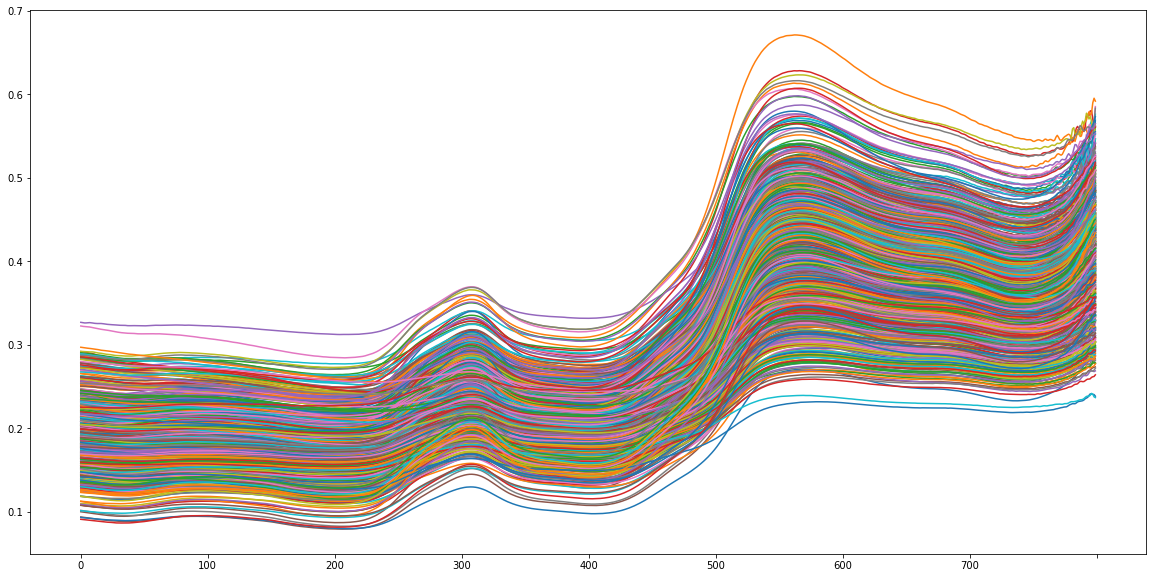

In [157]:
d_asta.drop(columns = 'ASTA').transpose().plot(figsize=(20,10),legend = False)

<AxesSubplot:>

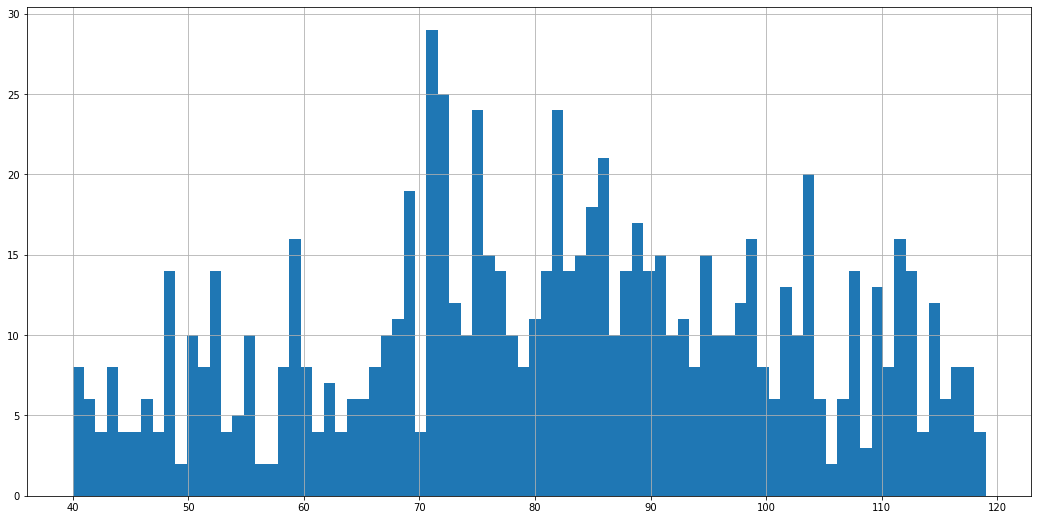

In [158]:
d_asta['ASTA'].hist(bins = r2-r1,figsize=(18,9))

### Outlier Removal

visualizing outlier using mahanlobis distance

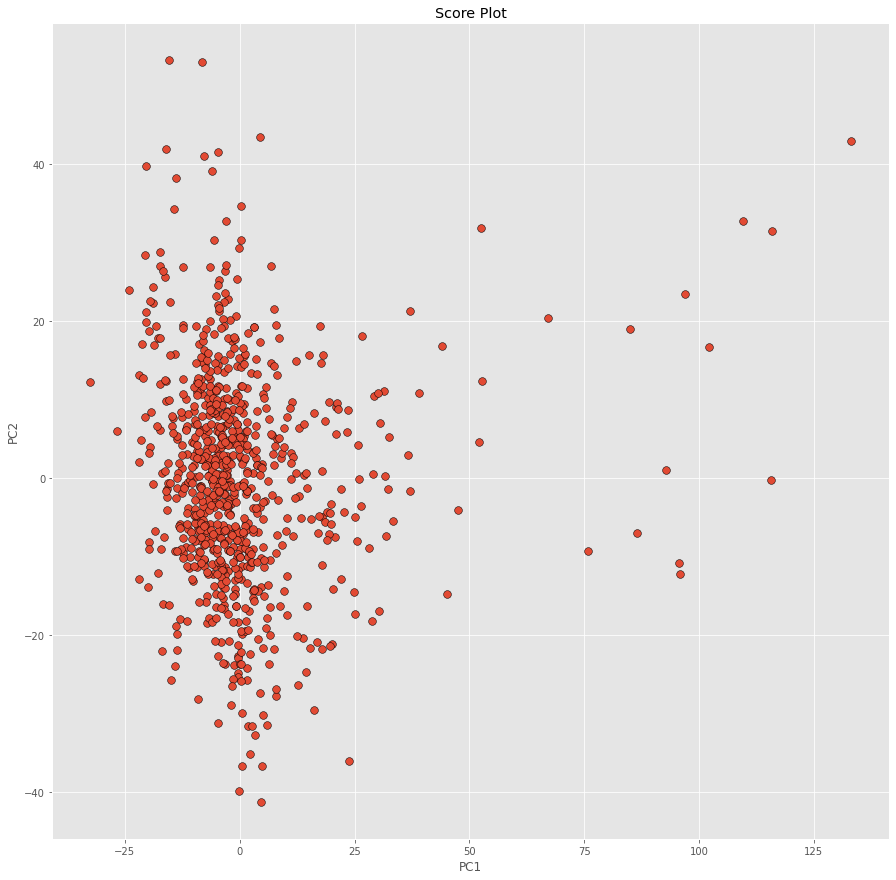

In [159]:
X_val = np.array(d_asta.drop(columns =['ASTA']))
X_val = savitzky(X_val,11,2)
X_val = MSC(X_val)
X_val = detrending(X_val)
X_val = derivate_first(X_val,11,2)

pca = PCA()
 
# Run PCA on scaled data and obtain the scores array
T = pca.fit_transform(StandardScaler().fit_transform(X_val))

robust_cov = MinCovDet().fit(T[:,:5])
 
# Get the Mahalanobis distance
m = robust_cov.mahalanobis(T[:,:5])

scat_plot(m,T[:,0],T[:,1])

##### Dropping Outliers and then plotting the new scatter plot

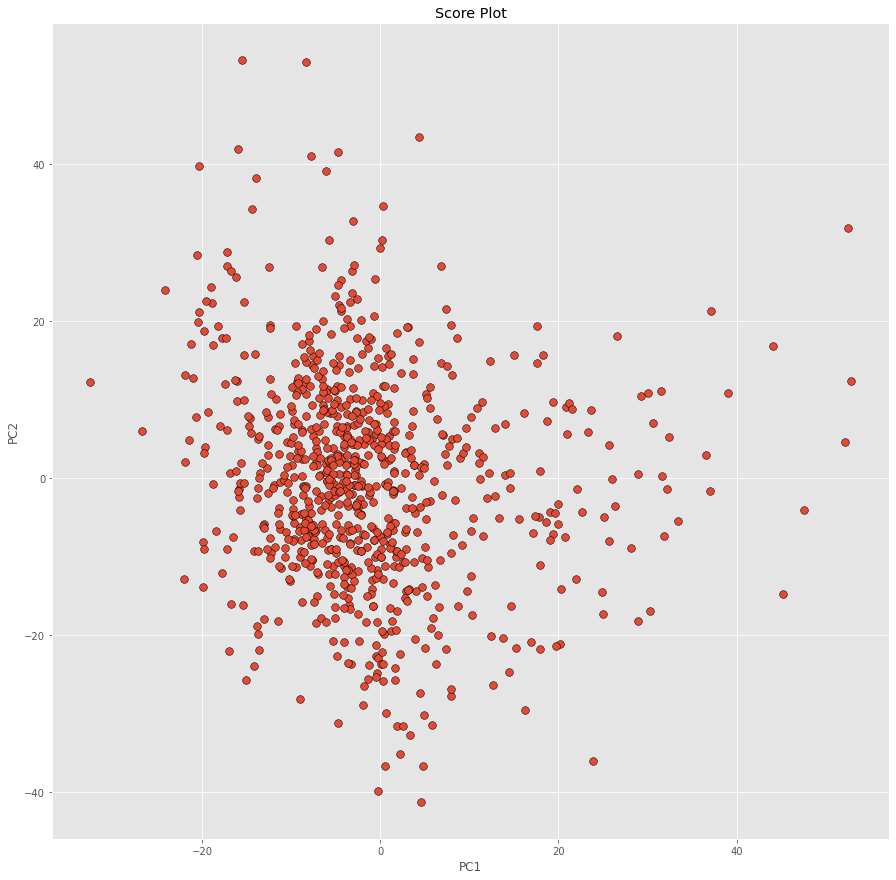

In [160]:
d_asta['mahan'] = m
d_asta['p'] = 1 - chi2.cdf(d_asta['mahan'], 4)
d_asta['ind'] = np.arange(len(m))
d_asta['PC0'] = T[:,0]

#d_asta_1 = d_asta.query('p == 0.e+00')
d_asta_1 = d_asta.query('PC0>60')
d_asta_2 = d_asta.drop(d_asta_1.index)
ind = d_asta_1['ind'].values

m_1 = np.delete(m,ind)

T_0 = np.delete(T[:,0],ind)
T_1 = np.delete(T[:,1],ind)

scat_plot(m_1,T_0,T_1)

#### Outliers Spectra and Histogram

<AxesSubplot:>

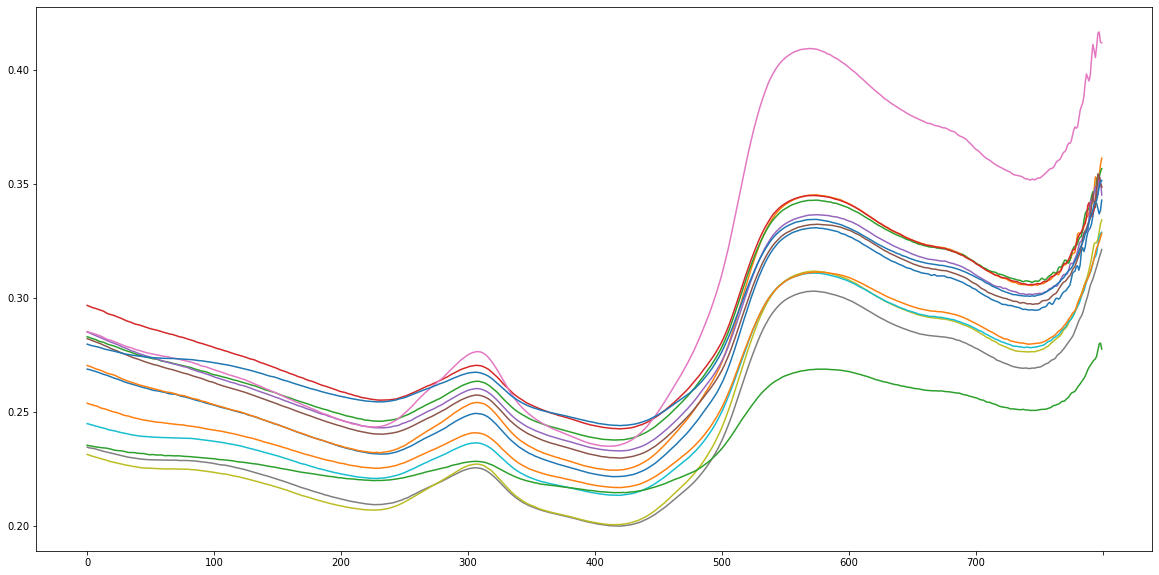

In [161]:
d_asta_1.drop(columns = ['ASTA','mahan','ind','p','PC0']).transpose().plot(figsize=(20,10),legend = False)

<AxesSubplot:>

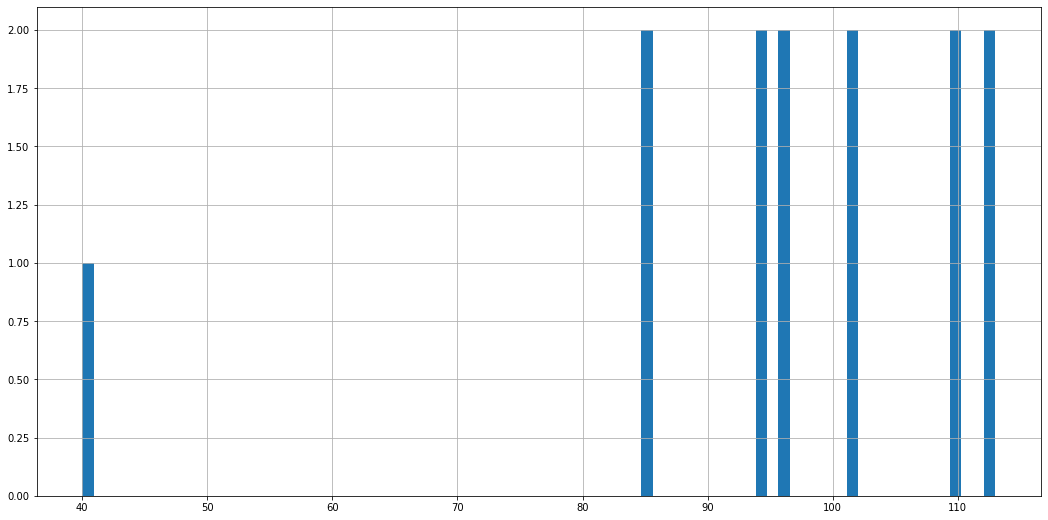

In [162]:
d_asta_1['ASTA'].hist(bins = r2-r1,figsize=(18,9))

#### Inliers Spectra and Histogram

<AxesSubplot:>

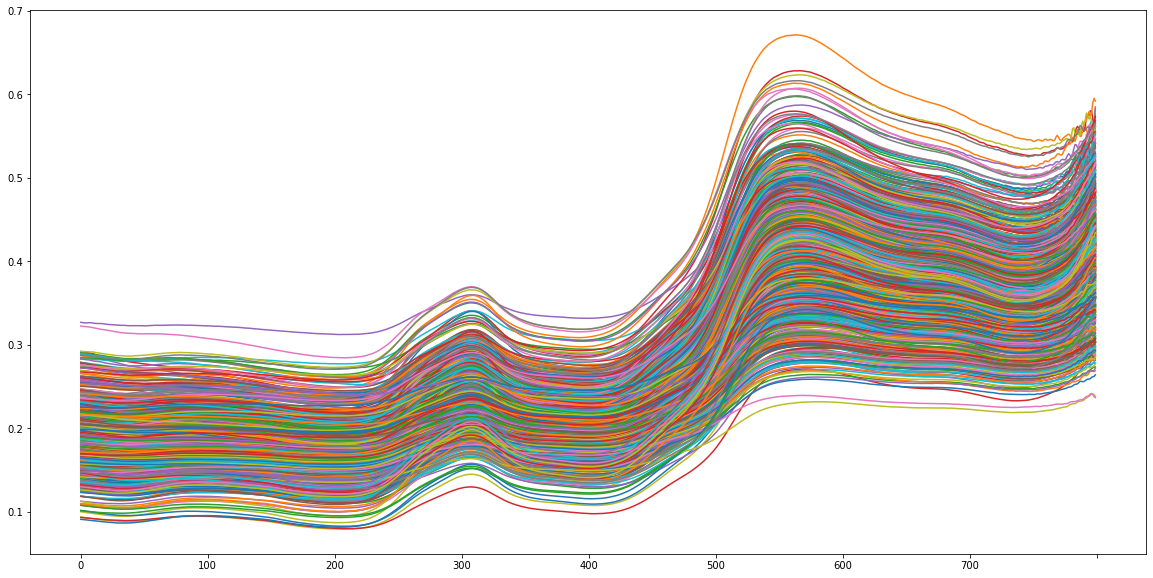

In [163]:
d_asta_2.drop(columns = ['ASTA','mahan','ind','p','PC0']).transpose().plot(figsize=(20,10),legend = False)

<AxesSubplot:>

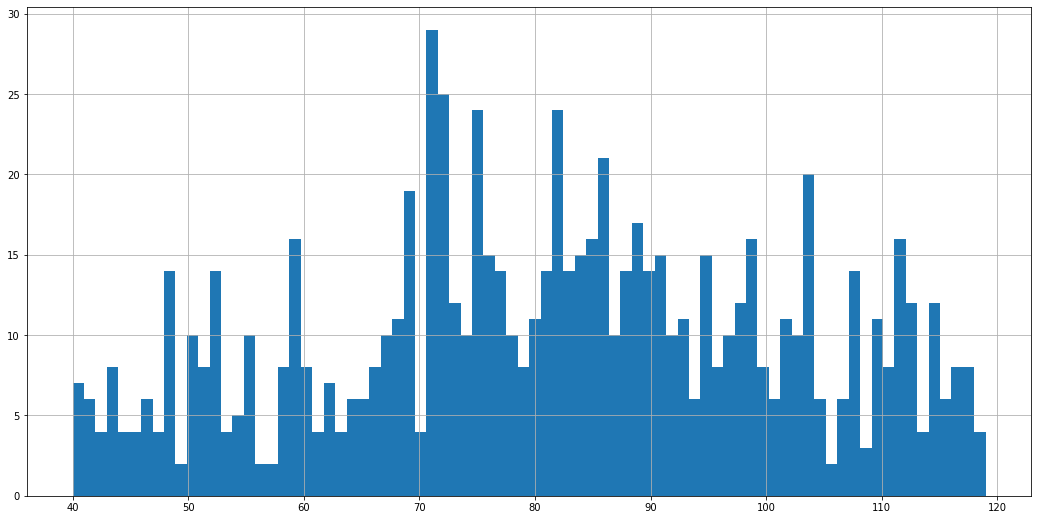

In [164]:
d_asta_2['ASTA'].hist(bins = r2-r1,figsize=(18,9))

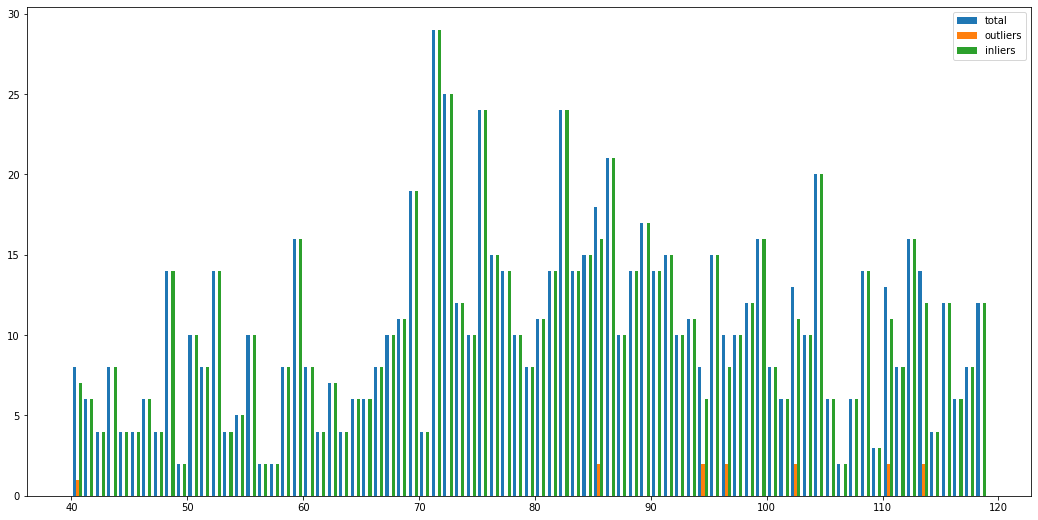

In [166]:
bins = np.arange(40,120)
total = d_asta['ASTA'].values
outliers = d_asta_1['ASTA'].values
inliers = d_asta_2['ASTA'].values
plt.figure(figsize = (18,9))
plt.hist([total,outliers,inliers],bins,label =['total','outliers','inliers'])
plt.legend()

In [139]:
d_asta_1['mahan'].values

array([421.35010999, 302.86792576, 405.13709661, 817.86474291,
       543.69948194, 571.23105089, 178.59215073, 406.74218667,
       251.13404201, 351.94729776, 624.2175447 , 397.24829166,
       472.64397962])

In [140]:
d_asta_1['p'].values

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

#### to plot outliers from inliners were outliers have p=0 in chi distribution

"for i in range(data_c_1_t.shape[0]):\n    if(data_c_1_t.iloc[i][0]==l1[0]):\n        data_c_1_t.iloc[i][1:].plot.line(ax=ax,color='red',label = str(l1[0]))\n    else:\n        data_c_1_t.iloc[i][1:].plot.line(ax=ax,color='green',label = str(l1[1]))\nimport matplotlib.patches as mpatches\n\n\nred_patch = mpatches.Patch(color='red', label=l1[0])\nblue_patch = mpatches.Patch(color='green', label=l1[1])\n\nax.legend(handles=[red_patch, blue_patch])\nfig_d_plot = fig.get_figure()\n# directory to save file\ndirt = 'C:\\Users\\Admin\\Desktop\\samples_report\\CHILI-001\\'+'d1 and d2'+'.png'\nfig_d_plot.savefig(dirt)"

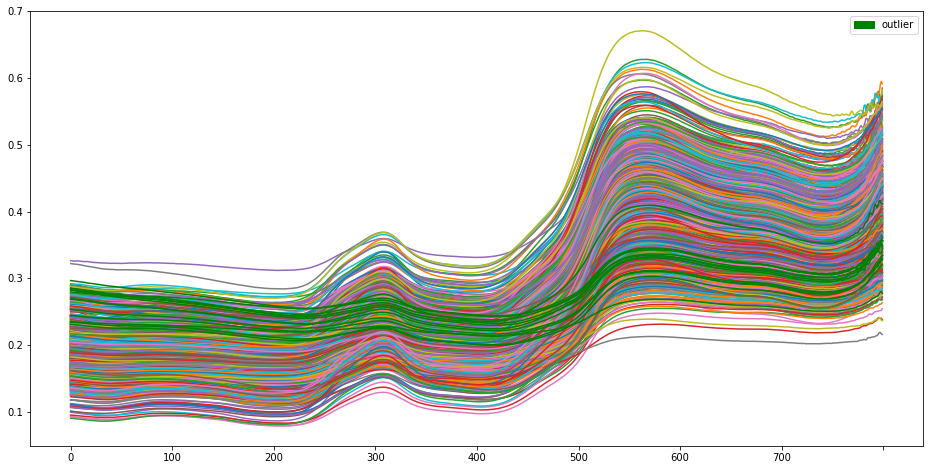

In [153]:
fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(1,1,1)
"""for i,r in d_asta_2.iterrows():
    gg = [str(x) for x in range(0,800)]
    ax.plot(r[gg].values,color = 'pink',label = 'inliner')"""

d_asta_2.drop(columns = ['ASTA','mahan','ind','p','PC0']).transpose().plot(ax = ax,legend = False)

for i,r in d_asta_1.iterrows():
    gg = [str(x) for x in range(0,800)]
    ax.plot(r[gg].values,color = 'green',label = 'outlier')

import matplotlib.patches as mpatches
#red_patch = mpatches.Patch(color='pink', label='inliner')
blue_patch = mpatches.Patch(color='green', label='outlier')

ax.legend(handles=[blue_patch])

"""for i in range(data_c_1_t.shape[0]):
    if(data_c_1_t.iloc[i][0]==l1[0]):
        data_c_1_t.iloc[i][1:].plot.line(ax=ax,color='red',label = str(l1[0]))
    else:
        data_c_1_t.iloc[i][1:].plot.line(ax=ax,color='green',label = str(l1[1]))
import matplotlib.patches as mpatches


red_patch = mpatches.Patch(color='red', label=l1[0])
blue_patch = mpatches.Patch(color='green', label=l1[1])

ax.legend(handles=[red_patch, blue_patch])
fig_d_plot = fig.get_figure()
# directory to save file
dirt = 'C:\\Users\\Admin\\Desktop\\samples_report\\CHILI-001\\'+'d1 and d2'+'.png'
fig_d_plot.savefig(dirt)"""

#### Training and testing data split

In [173]:
d_asta_3 = d_asta_2.drop(columns = ['mahan','p','ind','PC0'])

In [174]:
X_train = []
X_val = []
Y_train = []
Y_val = []

y = np.zeros(r2-r1,dtype=np.int32)
labels = d_asta_3['ASTA'].values
for label in labels:
    y[int(label)-r1]+=1

"""value_dict = {x:0 for x in range(r1,r2)}
labels = d_asta_2['ASTA']
        
for label in labels:
    value_dict[(int(label))]+=1"""

#l_1 = np.array([x for x in value_dict.values()])

for i in range(len(y)):
    if(y[i]>1):
        qr = 'ASTA=='+str(i+r1)
        data_asta_3 = d_asta_3.query(qr)
        data_asta_3_2 = data_asta_3.sample(n=1,random_state = sed)
        data_asta_3_1 = data_asta_3.drop(data_asta_3_2.index)
        
    X_train.append(np.array(data_asta_3_1.drop(columns = ['ASTA'])))
    Y_train.append(np.array(data_asta_3_1['ASTA']))
    X_val.append(np.array(data_asta_3_2.drop(columns = ['ASTA'])))
    Y_val.append(np.array(data_asta_3_2['ASTA']))
    
X_train = np.vstack(X_train)
Y_train = np.hstack(Y_train)
X_val = np.vstack(X_val)
Y_val = np.hstack(Y_val)

In [294]:
y_11 = y - 1

In [295]:
y_11

array([ 6,  5,  3,  7,  3,  3,  5,  3, 13,  1,  9,  7, 13,  3,  4,  9,  1,
        1,  7, 15,  7,  3,  6,  3,  5,  5,  7,  9, 10, 18,  3, 28, 24, 11,
        9, 23, 14, 13,  9,  7, 10, 13, 23, 13, 14, 15, 20,  9, 13, 16, 13,
       14,  9, 10,  5, 14,  7,  9, 11, 15,  7,  5, 10,  9, 19,  5,  1,  5,
       13,  2, 10,  7, 15, 11,  3, 11,  5,  7,  7,  3])

In [303]:
y_11_df = pd.DataFrame(y_11)

In [175]:
d_asta_train = pd.DataFrame(X_train)
d_asta_train['ASTA'] = Y_train

d_asta_test = pd.DataFrame(X_val)
d_asta_test['ASTA'] = pd.DataFrame(Y_val)

<AxesSubplot:>

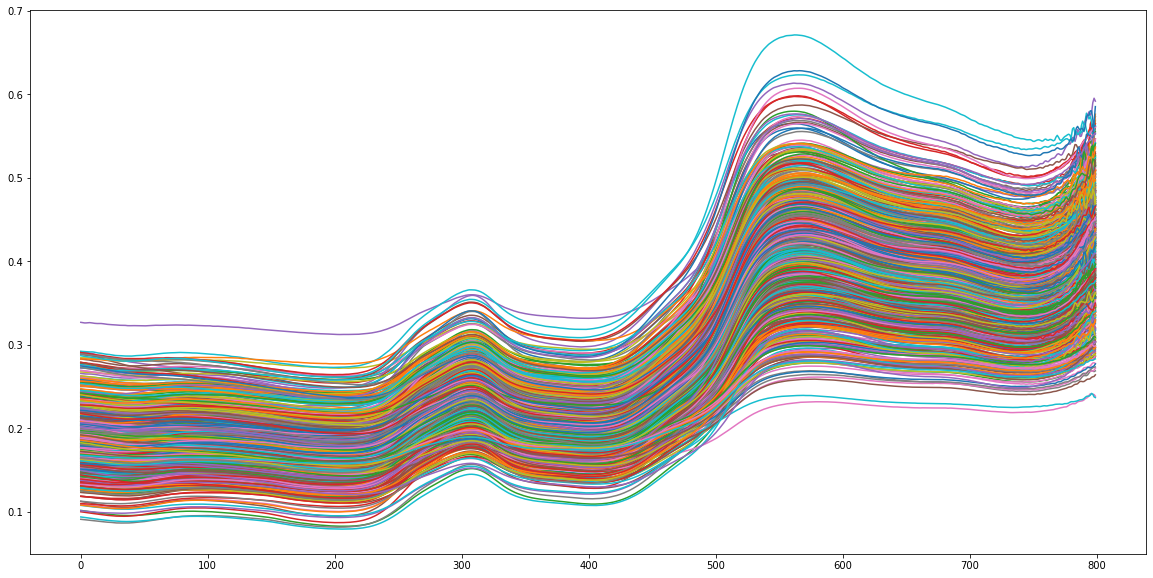

In [177]:
d_asta_train.drop(columns = ['ASTA']).transpose().plot(figsize=(20,10),legend = False)

<AxesSubplot:>

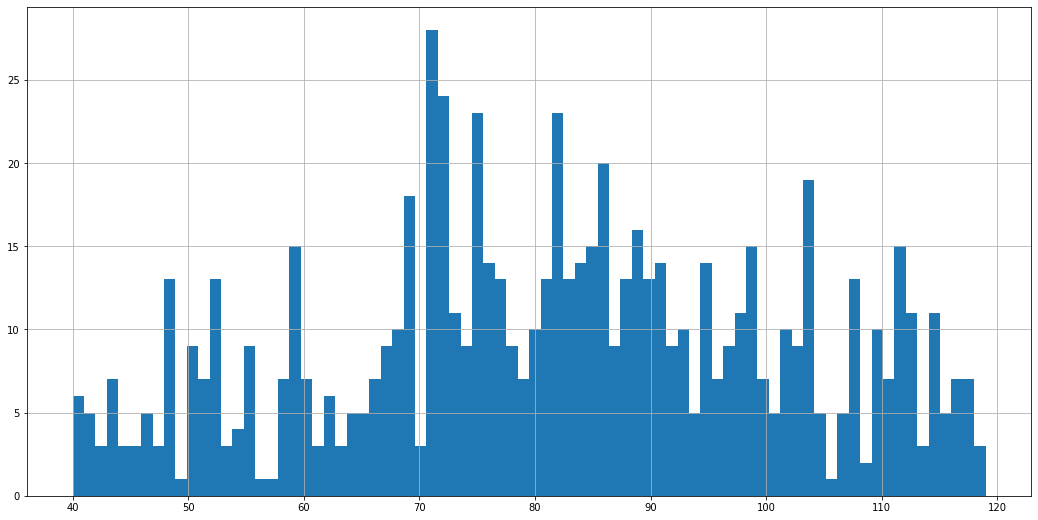

In [180]:
d_asta_train['ASTA'].hist(bins = r2-r1,figsize=(18,9))

<AxesSubplot:>

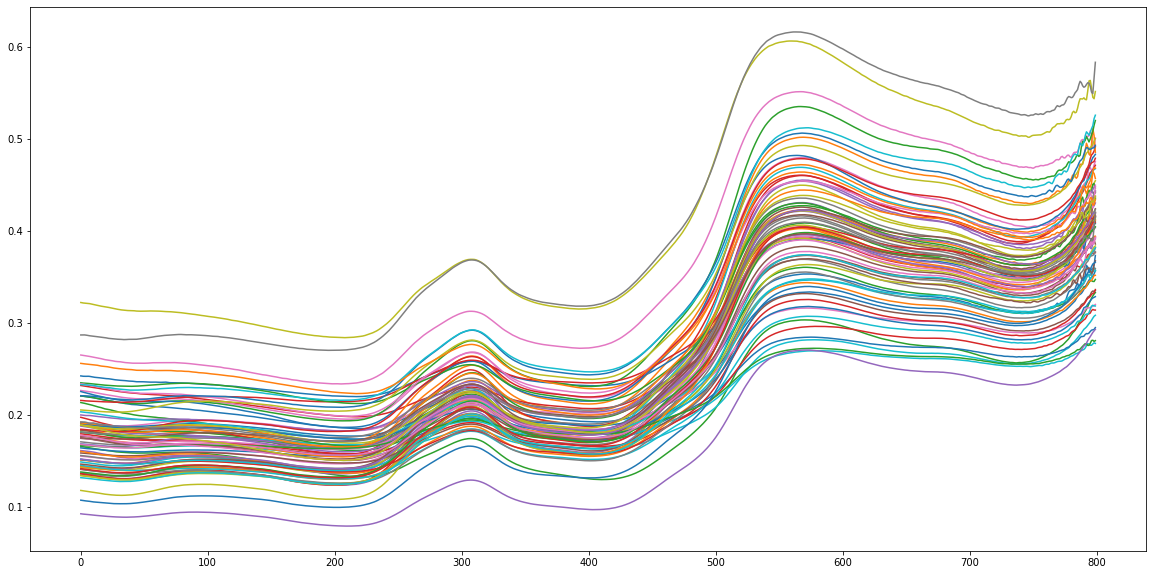

In [178]:
d_asta_test.drop(columns = ['ASTA']).transpose().plot(figsize=(20,10),legend = False)

<AxesSubplot:>

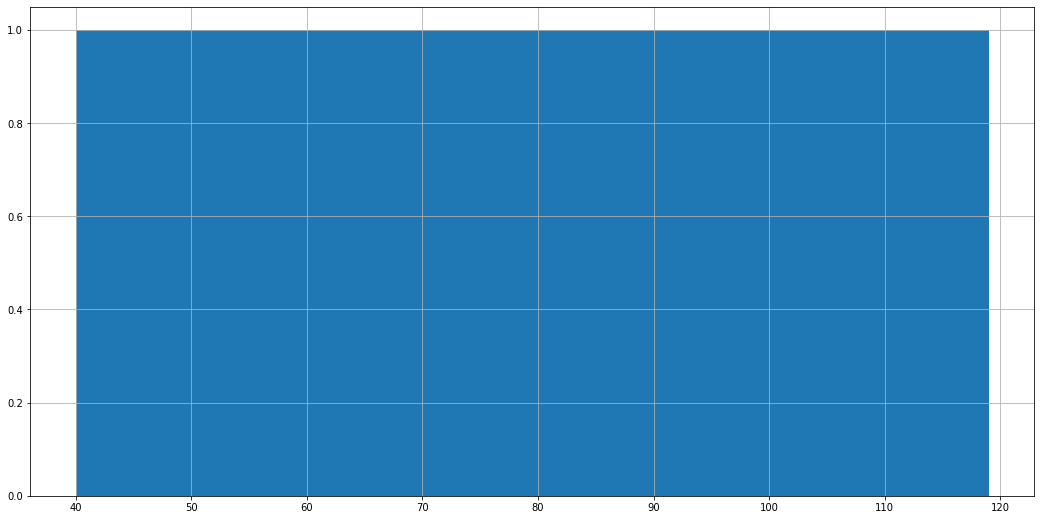

In [181]:
d_asta_test['ASTA'].hist(bins = r2-r1,figsize=(18,9))

#### combined train and test spectra

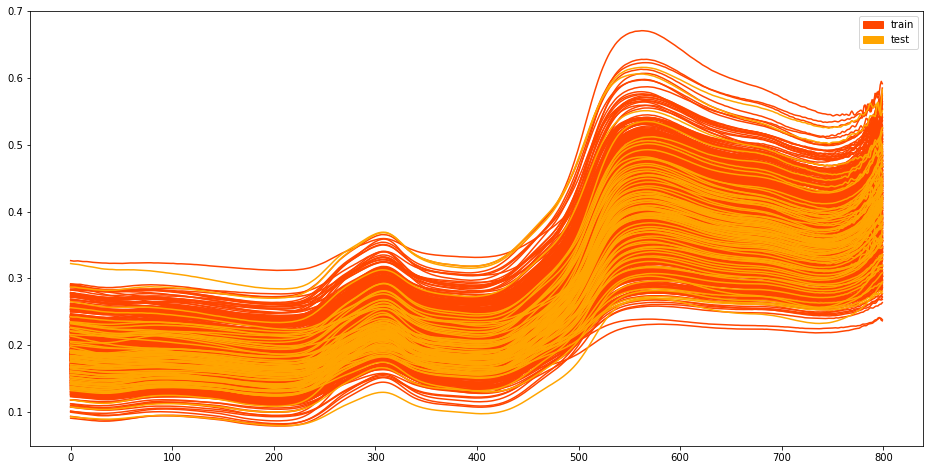

In [188]:
fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(1,1,1)
for i,r in d_asta_train.iterrows():
    gg = [x for x in range(0,800)]
    ax.plot(r[gg].values,color = 'orangered',label = 'train')

for i,r in d_asta_test.iterrows():
    gg = [x for x in range(0,800)]
    ax.plot(r[gg].values,color = 'orange',label = 'test')

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='orangered', label='train')
blue_patch = mpatches.Patch(color='orange', label='test')

ax.legend(handles=[red_patch,blue_patch])

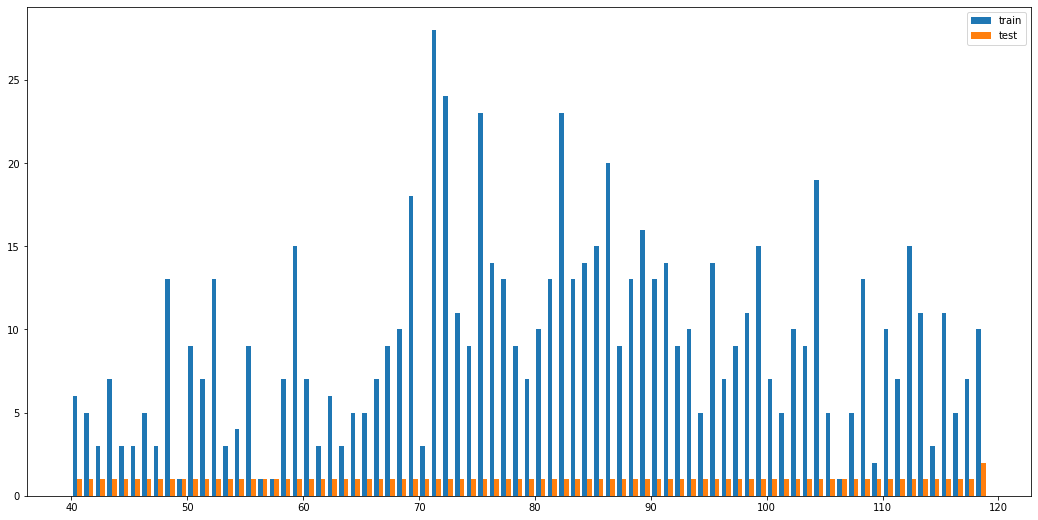

In [189]:
bins = np.arange(40,120)
train = d_asta_train['ASTA'].values
test = d_asta_test['ASTA'].values
plt.figure(figsize = (18,9))
plt.hist([train,test],bins,label =['train','test'])
plt.legend()

#### Applying Label Distribution Smoothing to the Training Data Distribution

In [196]:
wt,smooted_val,window = get_weights(y)

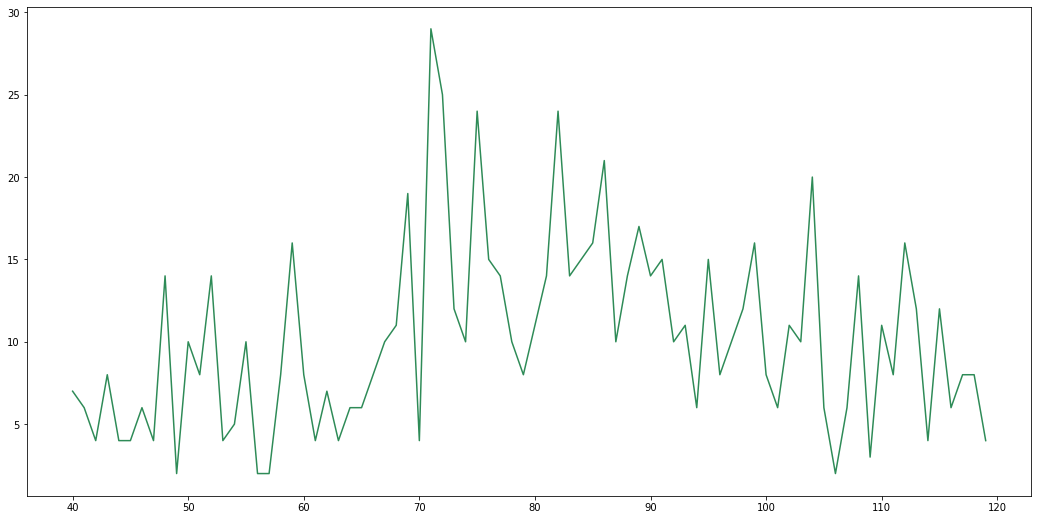

In [197]:
plt.figure(figsize = (18,9))
plt.plot(np.arange(r1,r2),y,color='seagreen')

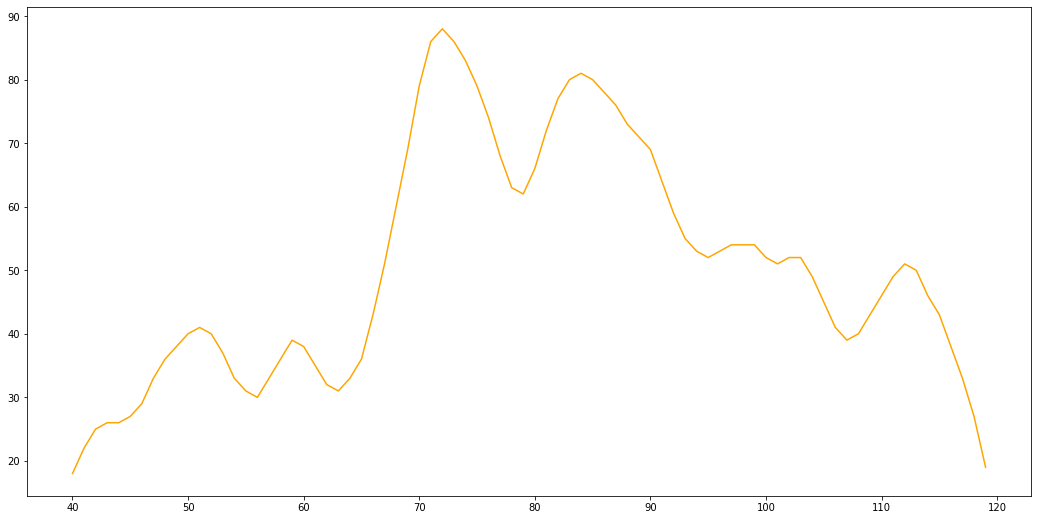

In [201]:
plt.figure(figsize = (18,9))
plt.plot(np.arange(r1,r2),smooted_val,color='orange')

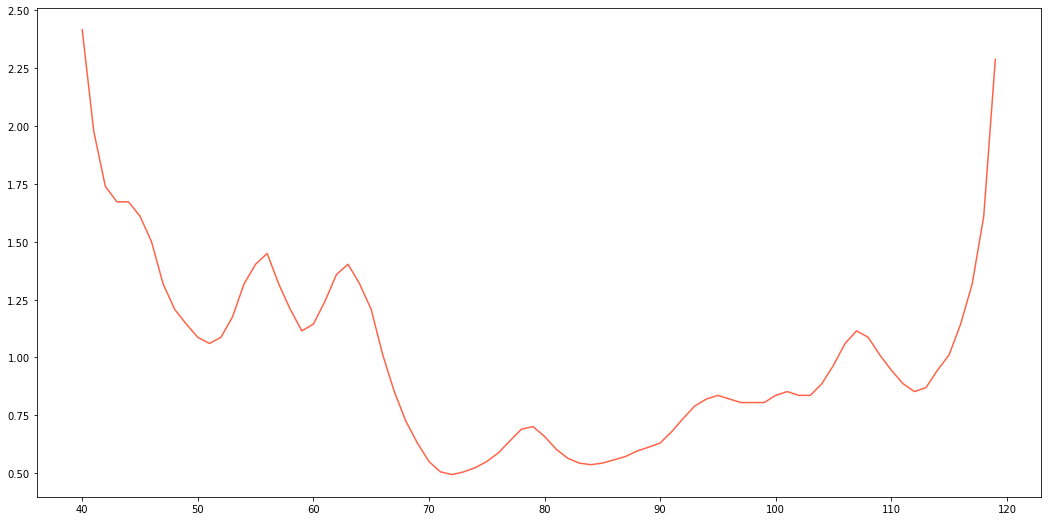

In [203]:
plt.figure(figsize = (18,9))
plt.plot(np.arange(r1,r2),wt,color='tomato')

In [222]:
import sklearn.metrics as met

In [207]:
sdf = pd.read_csv('C:/Users/Admin/Desktop/best_asta_lds_csv/chili_train_actual_pred_lds.csv',encoding = 'utf-8')

In [218]:
sdf = sdf.dropna()

In [219]:
sdf

Unnamed: 0  actual  predcted  MAE   MAPE
0         164.0    40.0      38.0  2.0  95.00
1         389.0    40.0      31.0  9.0  77.50
2         130.0    41.0      44.0  3.0  92.68
3         235.0    41.0      42.0  1.0  97.56
4         499.0    41.0      40.0  1.0  97.56
..          ...     ...       ...  ...    ...
731       205.0   119.0     113.0  6.0  94.96
732       293.0   119.0     110.0  9.0  92.44
733       453.0   119.0     113.0  6.0  94.96
734       473.0   119.0     110.0  9.0  92.44
735       649.0   119.0     113.0  6.0  94.96

[736 rows x 5 columns]

In [220]:
pred = np.asarray(sdf['predcted'])

In [221]:
act = np.asarray(sdf['actual'])

In [223]:
met.r2_score(pred,act)

0.8665196555297456

d_asta_test.to_csv('test_data.csv')

### Analysis of spectra from diff_test

In [283]:
sed = 100
r1 = 65
r2 = 66
df = pd.read_csv('diff_test.csv')
col = ['Sample ID','Cap','800']
#col = [str(x) for x in range(0,151)]+[str(x) for x in range(751,801)]+['Sample ID','Cap']
d_asta = df.drop(columns=col)
d_asta = d_asta.dropna(subset=['ASTA'])
d_asta['ASTA'] = d_asta['ASTA'].round()
d_asta = d_asta[d_asta['ASTA']>=r1]
d_asta = d_asta[d_asta['ASTA']<r2]

In [282]:
sed = 100
r1 = 65
r2 = 66
df = pd.read_csv('chili-001.csv')
col = ['Sample ID','Cap','800']
#col = [str(x) for x in range(0,151)]+[str(x) for x in range(751,801)]+['Sample ID','Cap']
d_asta_2 = df.drop(columns=col)
d_asta_2 = d_asta_2.dropna(subset=['ASTA'])
d_asta_2['ASTA'] = d_asta_2['ASTA'].round()
d_id = [*(set(d_asta_2['Device ID']))]
d_asta_2 = d_asta_2.query("ASTA>="+str(r1)+"&"+"ASTA<"+str(r2))
d_asta_3 = d_asta_2[d_asta_2["Device ID"] == str(d_id[0])]
d_asta_4 = d_asta_2[d_asta_2["Device ID"] == str(d_id[1])]

d_asta_3 = d_asta_3.drop(columns = ['Device ID'])
d_asta_4 = d_asta_4.drop(columns = ["Device ID"])

In [266]:
def prepro(X):
    X_val = savitzky(X,11,2)
    X_val = MSC(X_val)
    X_val = detrending(X_val)
    X_val = derivate_first(X_val,11,2)
    return X_val

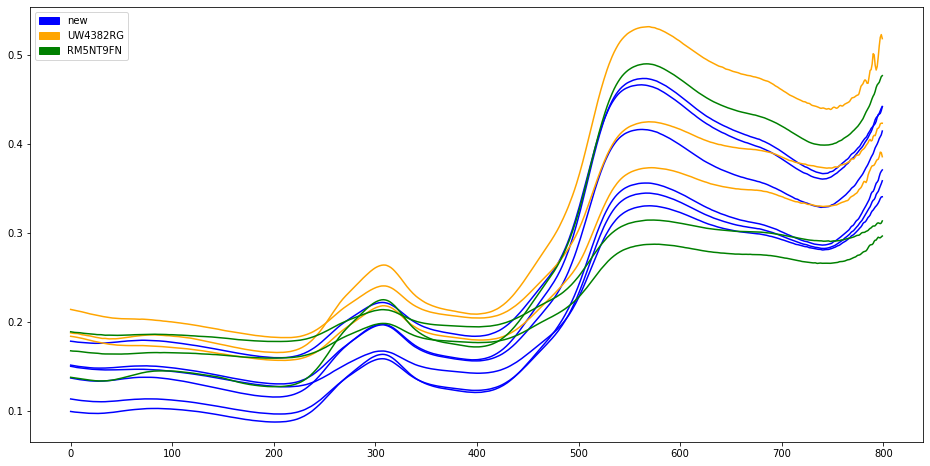

In [286]:
fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(1,1,1)

x_val_1 = np.array(d_asta.drop(columns = 'ASTA'))
x_val_2 = np.array(d_asta_3.drop(columns = 'ASTA'))
x_val_3 = np.array(d_asta_4.drop(columns = 'ASTA'))

ax.plot(x_val_1.transpose(),color = 'blue',label = 'new')
ax.plot(x_val_2.transpose(),color = 'orange',label = d_id[0])
ax.plot(x_val_3.transpose(),color = 'green',label = d_id[1])

import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(color='blue', label='new')
orange_patch = mpatches.Patch(color='orange', label=d_id[0])
green_patch = mpatches.Patch(color='green', label=d_id[1])

ax.legend(handles=[red_patch,orange_patch,green_patch])

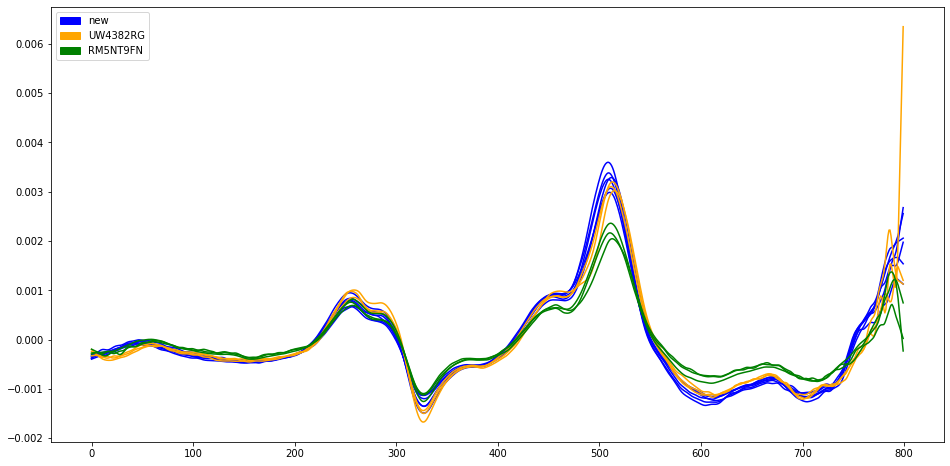

In [284]:
fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(1,1,1)

x_val_1 = prepro(np.array(d_asta.drop(columns = 'ASTA')))
x_val_2 = prepro(np.array(d_asta_3.drop(columns = 'ASTA')))
x_val_3 = prepro(np.array(d_asta_4.drop(columns = 'ASTA')))

ax.plot(x_val_1.transpose(),color = 'blue',label = 'new')
ax.plot(x_val_2.transpose(),color = 'orange',label = d_id[0])
ax.plot(x_val_3.transpose(),color = 'green',label = d_id[1])

import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(color='blue', label='new')
orange_patch = mpatches.Patch(color='orange', label=d_id[0])
green_patch = mpatches.Patch(color='green', label=d_id[1])

ax.legend(handles=[red_patch,orange_patch,green_patch])

### Data Analsis for chili - Cap

In [305]:
sed = 100
r1 = 30_000
r2 = 87_000
df = pd.read_csv('chili-001.csv')
col = ['Sample ID','ASTA','800','Device ID']
d_cap = df.drop(columns=col)
d_cap = d_cap.dropna(subset=['Cap'])
d_cap['Cap'] = d_cap['Cap']
d_cap = d_cap[d_cap['Cap']>=r1]
d_cap = d_cap[d_cap['Cap']<r2]

<AxesSubplot:>

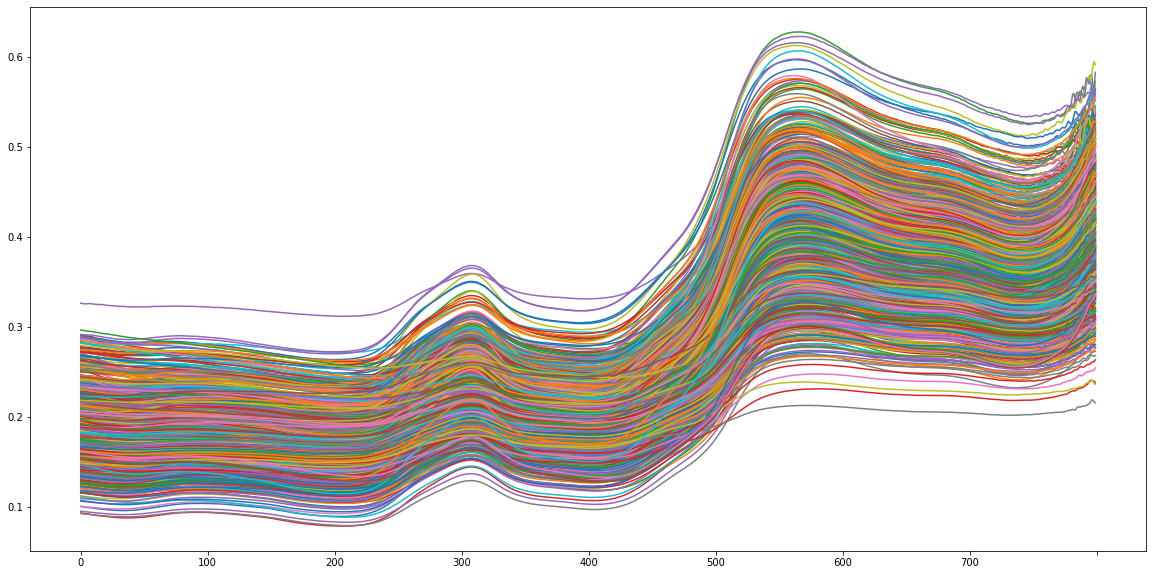

In [307]:
d_cap.drop(columns = 'Cap').transpose().plot(figsize=(20,10),legend = False)

<AxesSubplot:>

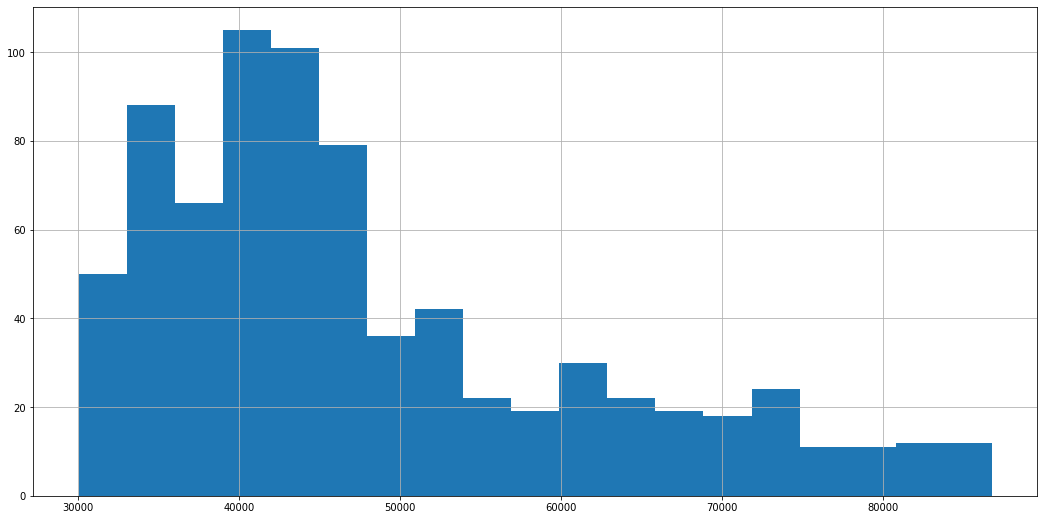

In [309]:
d_cap['Cap'].hist(bins = int((r2-r1)/3_000),figsize=(18,9))

### Visualizing outlier using Mahalanobis distance

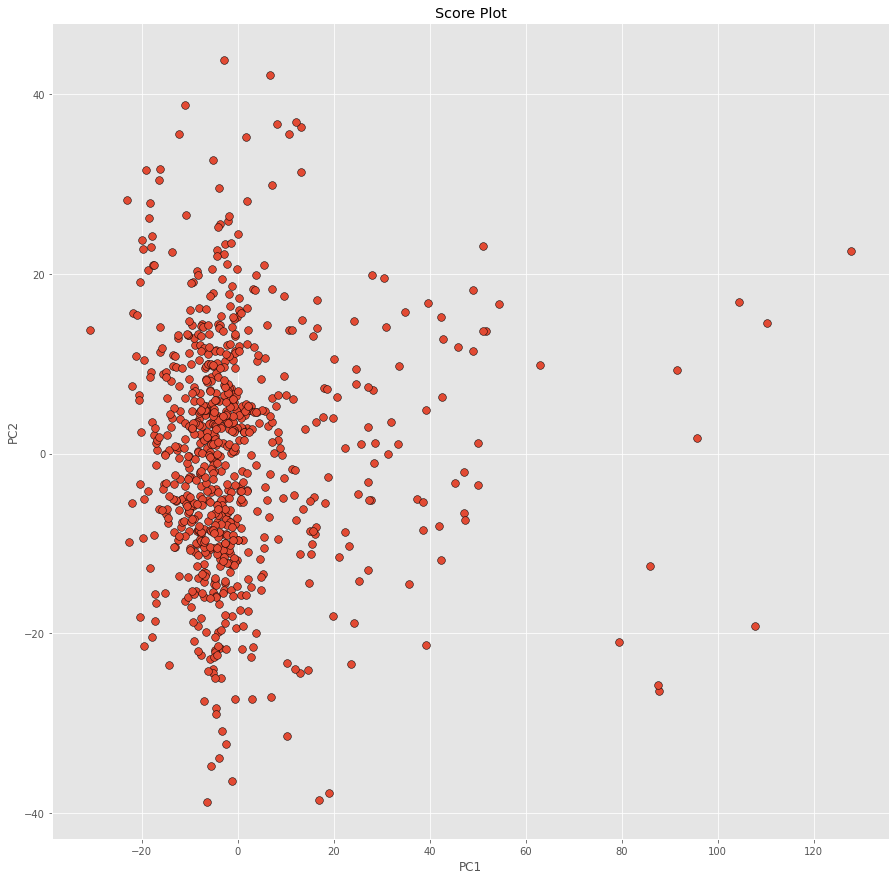

In [310]:
X_val = np.array(d_cap.drop(columns =['Cap']))
X_val = savitzky(X_val,11,2)
X_val = MSC(X_val)
X_val = detrending(X_val)
X_val = derivate_first(X_val,11,2)

pca = PCA()
 
# Run PCA on scaled data and obtain the scores array
T = pca.fit_transform(StandardScaler().fit_transform(X_val))

robust_cov = MinCovDet().fit(T[:,:5])
 
# Get the Mahalanobis distance
m = robust_cov.mahalanobis(T[:,:5])

scat_plot(m,T[:,0],T[:,1])

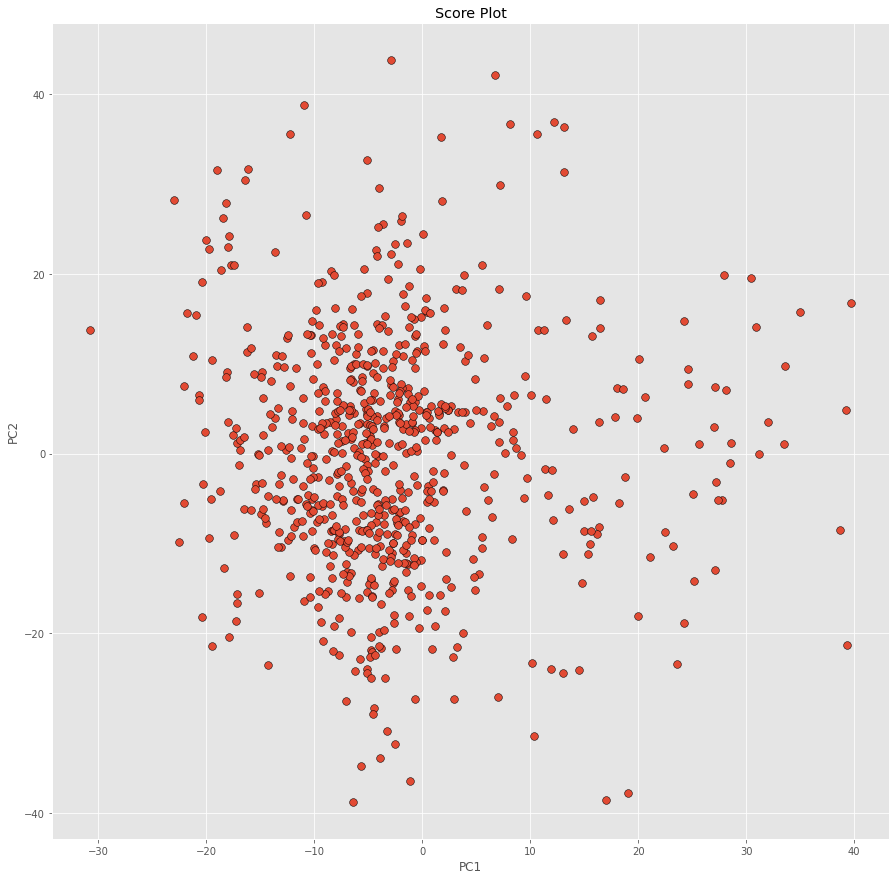

In [312]:
d_cap['mahan'] = m
d_cap['p'] = 1 - chi2.cdf(d_cap['mahan'], 4)
d_cap['ind'] = np.arange(len(m))
d_cap['PC0'] = T[:,0]

d_cap_1 = d_cap.query('p == 0.e+00')
#d_asta_1 = d_asta.query('PC0>60')
d_cap_2 = d_cap.drop(d_cap_1.index)
ind = d_cap_1['ind'].values

m_1 = np.delete(m,ind)

T_0 = np.delete(T[:,0],ind)
T_1 = np.delete(T[:,1],ind)

scat_plot(m_1,T_0,T_1)

#### outlier spectra of cap

<AxesSubplot:>

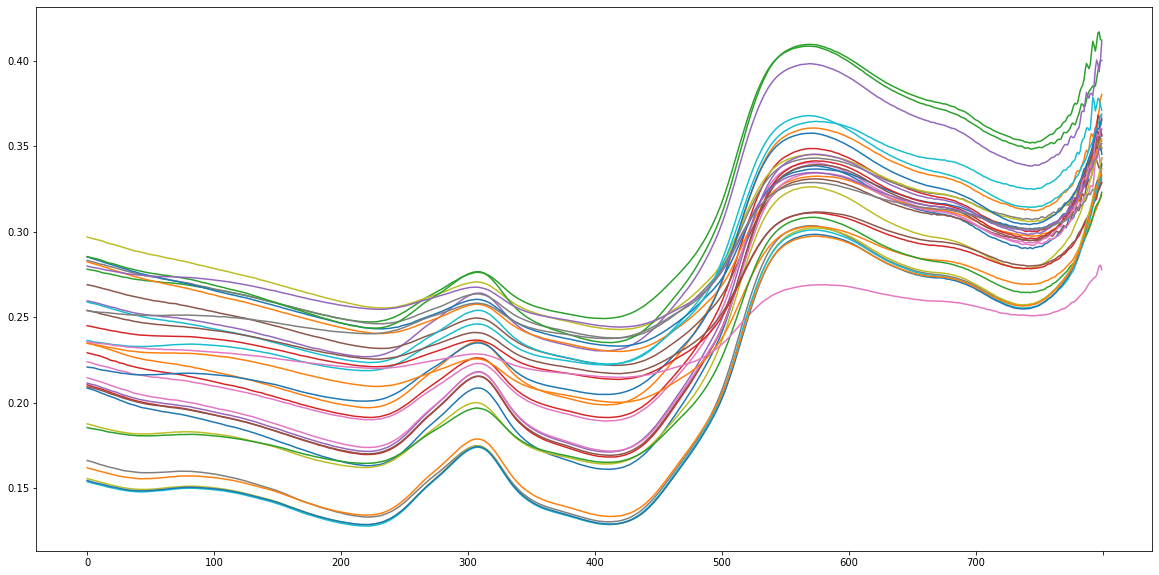

In [313]:
d_cap_1.drop(columns = ['Cap','mahan','ind','p','PC0']).transpose().plot(figsize=(20,10),legend = False)

<AxesSubplot:>

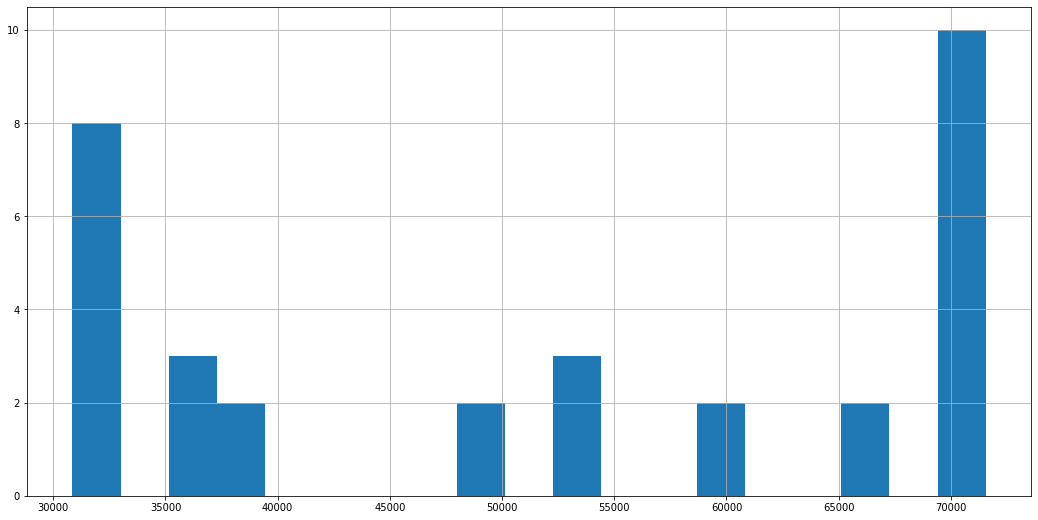

In [315]:
d_cap_1['Cap'].hist(bins = int((r2-r1)/3_000),figsize=(18,9))

#### inliner spectra and histogram

<AxesSubplot:>

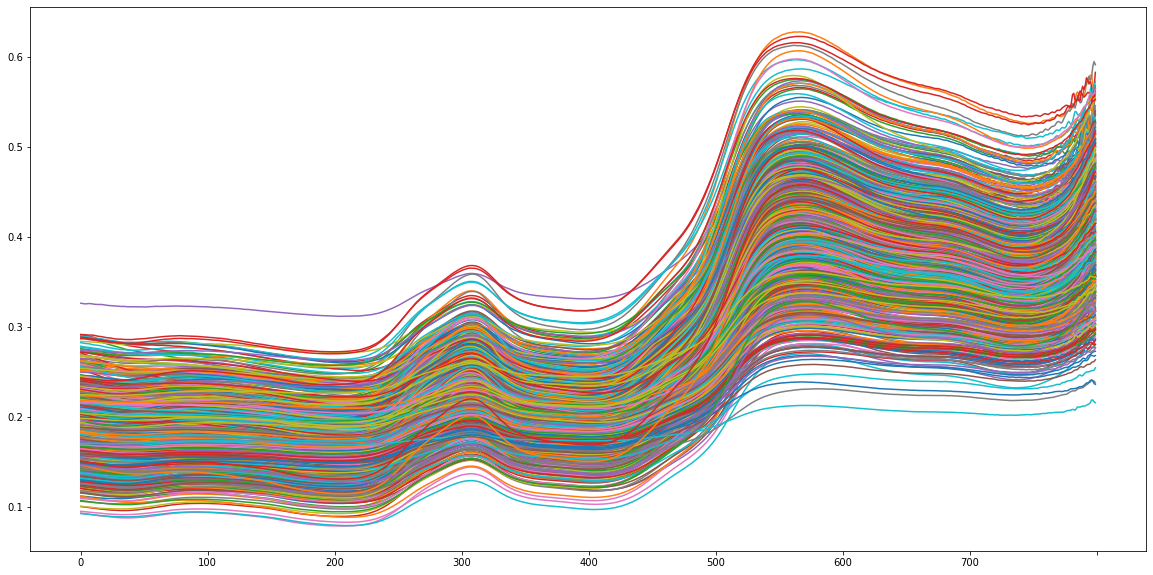

In [317]:
d_cap_2.drop(columns = ['Cap','mahan','ind','p','PC0']).transpose().plot(figsize=(20,10),legend = False)

<AxesSubplot:>

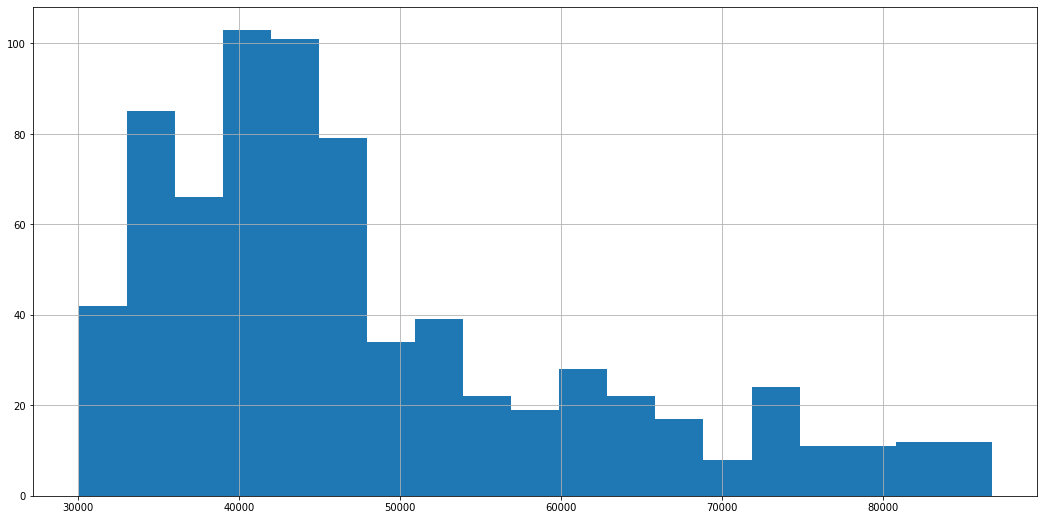

In [318]:
d_cap_2['Cap'].hist(bins = int((r2-r1)/3_000),figsize=(18,9))

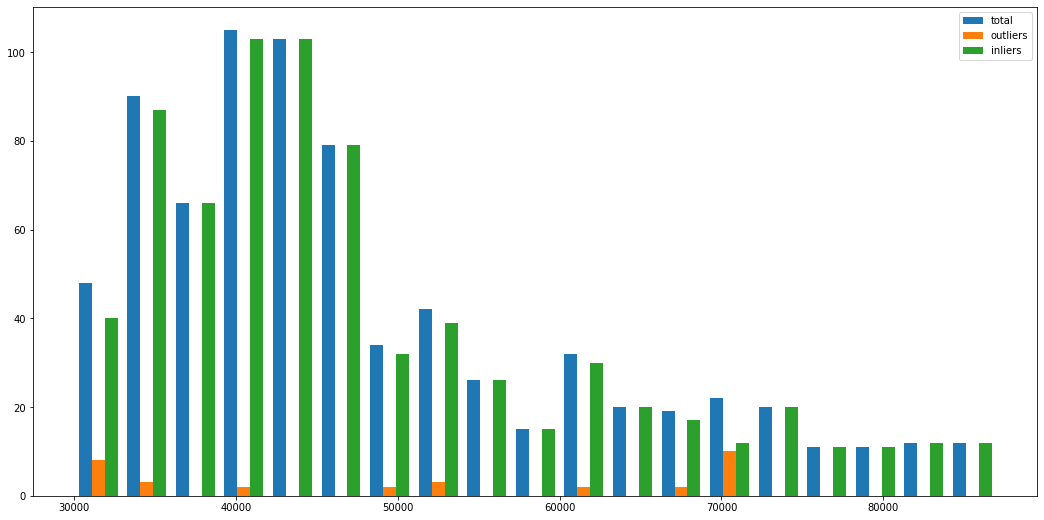

In [319]:
bins = np.arange(30_000,90_000,3_000)
total = d_cap['Cap'].values
outliers = d_cap_1['Cap'].values
inliers = d_cap_2['Cap'].values
plt.figure(figsize = (18,9))
plt.hist([total,outliers,inliers],bins,label =['total','outliers','inliers'])
plt.legend()

In [320]:
d_cap_1['mahan'].values , d_cap_1['p'].values

(array([125.09200457,  84.65653278, 113.46402499,  95.91220478,
         92.66481626, 370.68025895, 112.64062874, 351.35249773,
        707.30687574,  87.939855  , 455.27373971, 489.05507719,
        180.97722667, 115.4873374 , 110.94717688, 115.61497535,
        134.98761824, 146.91845555,  90.84157252,  96.45250518,
         84.97406411, 347.96863785,  93.47347208, 292.32848648,
        528.88237335, 313.257004  , 347.48297924,  95.9147775 ,
        120.22179597, 116.15737036, 123.42355215, 140.98258288]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

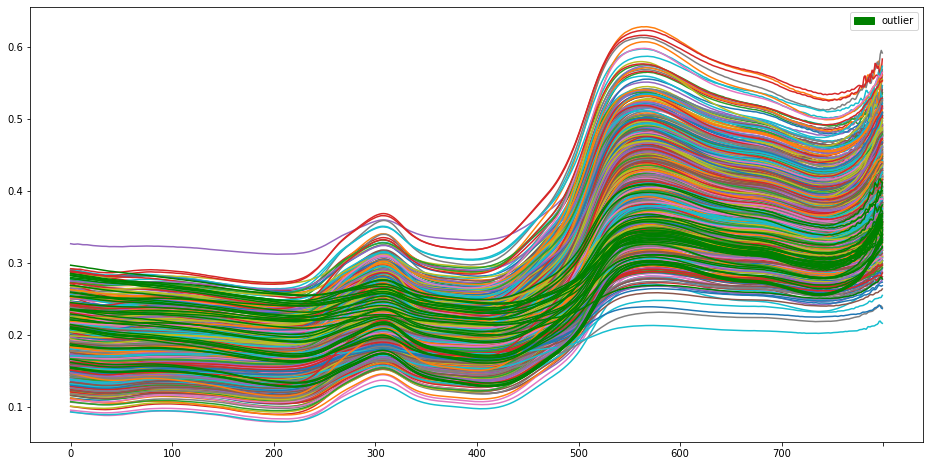

In [321]:
fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(1,1,1)

d_cap_2.drop(columns = ['Cap','mahan','ind','p','PC0']).transpose().plot(ax = ax,legend = False)

for i,r in d_cap_1.iterrows():
    gg = [str(x) for x in range(0,800)]
    ax.plot(r[gg].values,color = 'green',label = 'outlier')

import matplotlib.patches as mpatches
#red_patch = mpatches.Patch(color='pink', label='inliner')
blue_patch = mpatches.Patch(color='green', label='outlier')

ax.legend(handles=[blue_patch])

#### training and testing data_split

In [322]:
d_cap_3 = d_cap_2.drop(columns = ['mahan','p','ind','PC0'])

In [323]:
X_train = []
X_val = []
Y_train = []
Y_val = []

y = np.zeros(int((r2-r1)/3_000),dtype=np.int32)
labels = d_cap_3['Cap'].values
for label in labels:
    y[int((label-r1)/3_000)]+=1

"""value_dict = {x:0 for x in range(r1,r2)}
labels = d_asta_2['ASTA']
        
for label in labels:
    value_dict[(int(label))]+=1"""

#l_1 = np.array([x for x in value_dict.values()])

for i in range(len(y)):
    if(y[i]>1):
        qr = 'Cap>='+str(i*3_000+r1)+'&'+'Cap<'+str((i+1)*3_000+r1)
        data_cap_3 = d_cap_3.query(qr)
        data_cap_3_2 = data_cap_3.sample(n=4,random_state = sed)
        data_cap_3_1 = data_cap_3.drop(data_cap_3_2.index)
        
    X_train.append(np.array(data_cap_3_1.drop(columns = ['Cap'])))
    Y_train.append(np.array(data_cap_3_1['Cap']))
    X_val.append(np.array(data_cap_3_2.drop(columns = ['Cap'])))
    Y_val.append(np.array(data_cap_3_2['Cap']))
    
X_train = np.vstack(X_train)
Y_train = np.hstack(Y_train)
X_val = np.vstack(X_val)
Y_val = np.hstack(Y_val)

In [324]:
d_cap_train = pd.DataFrame(X_train)
d_cap_train['Cap'] = Y_train

d_cap_test = pd.DataFrame(X_val)
d_cap_test['Cap'] = pd.DataFrame(Y_val)

<AxesSubplot:>

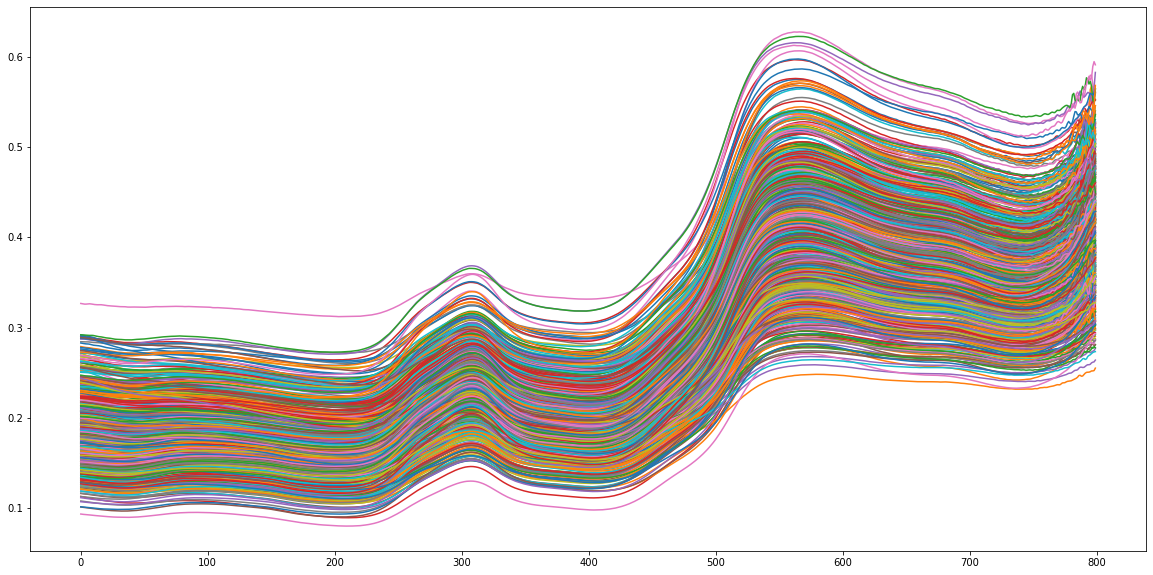

In [327]:
d_cap_train.drop(columns = ['Cap']).transpose().plot(figsize=(20,10),legend = False)

<AxesSubplot:>

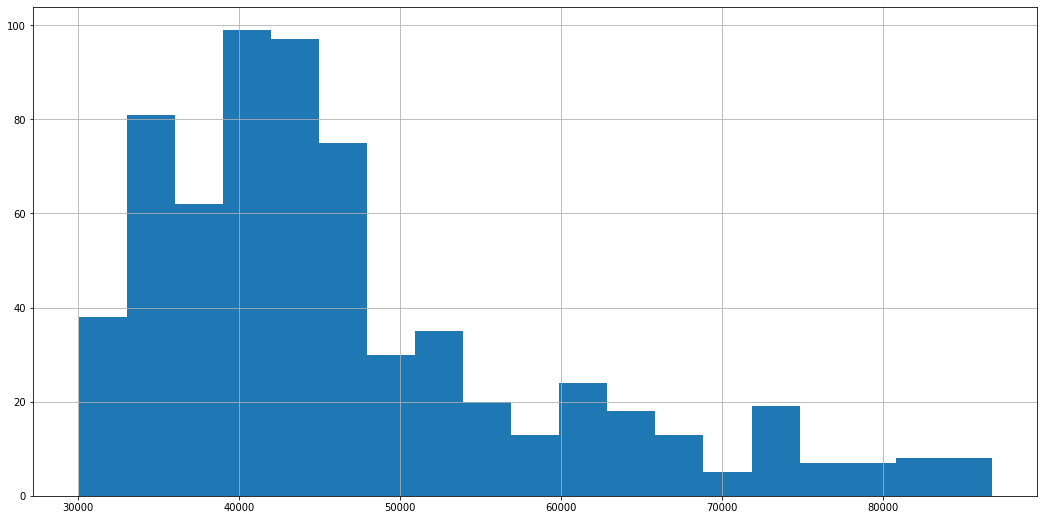

In [328]:
d_cap_train['Cap'].hist(bins = int((r2-r1)/3_000),figsize=(18,9))

<AxesSubplot:>

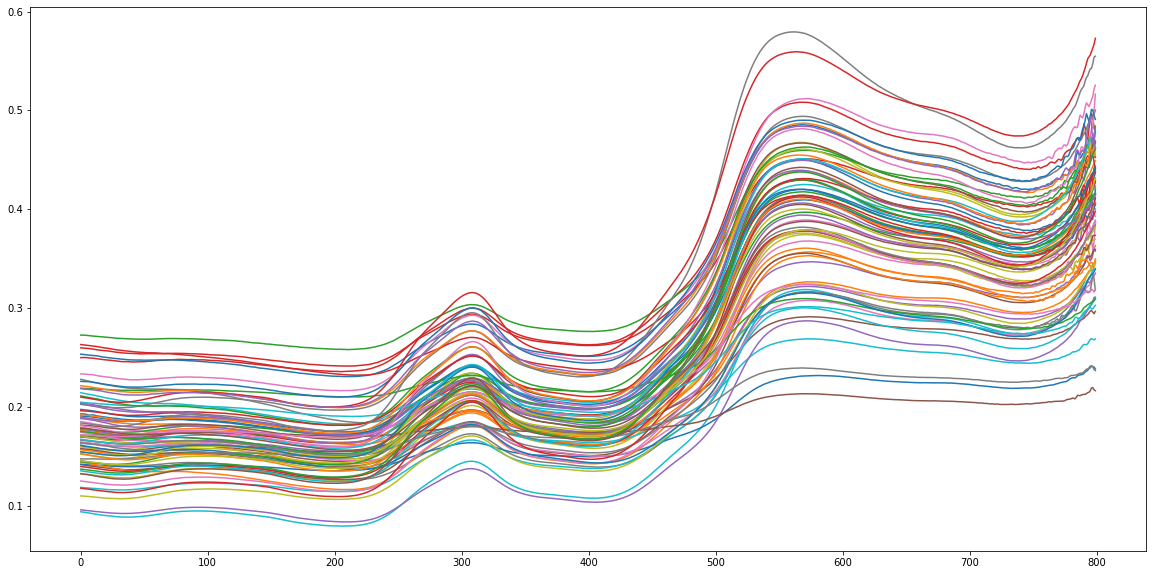

In [329]:
d_cap_test.drop(columns = ['Cap']).transpose().plot(figsize=(20,10),legend = False)

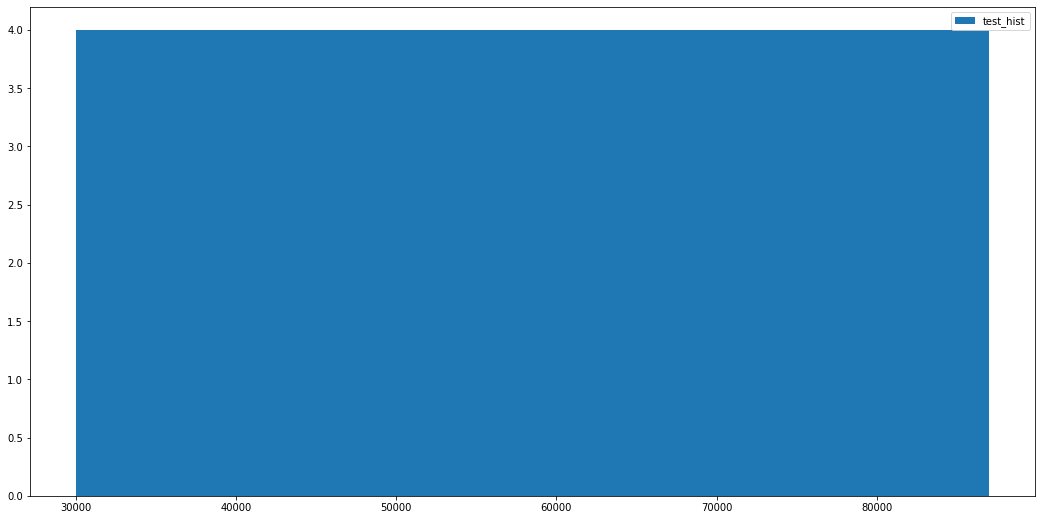

In [332]:
bins = np.arange(30_000,90_000,3_000)
test_hist = d_cap_test['Cap'].values
plt.figure(figsize = (18,9))
plt.hist([test_hist],bins,label =['test_hist'])
plt.legend()

#### Combuned trained and test spectra

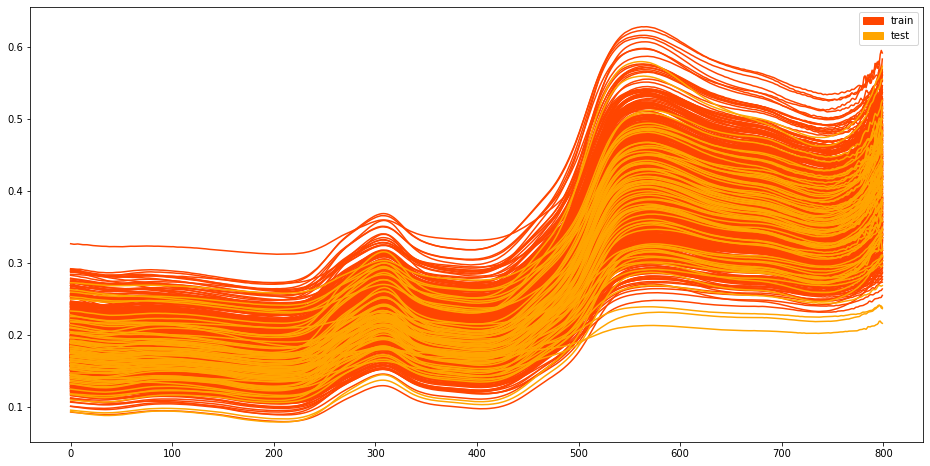

In [333]:
fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(1,1,1)
for i,r in d_cap_train.iterrows():
    gg = [x for x in range(0,800)]
    ax.plot(r[gg].values,color = 'orangered',label = 'train')

for i,r in d_cap_test.iterrows():
    gg = [x for x in range(0,800)]
    ax.plot(r[gg].values,color = 'orange',label = 'test')

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='orangered', label='train')
blue_patch = mpatches.Patch(color='orange', label='test')

ax.legend(handles=[red_patch,blue_patch])

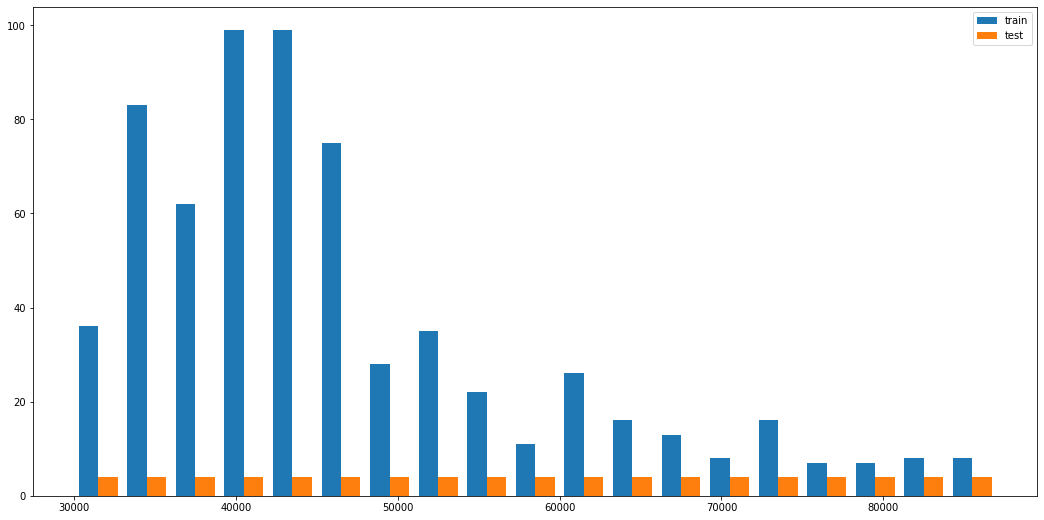

In [335]:
bins = np.arange(30_000,90_000,3_000)
train = d_cap_train['Cap'].values
test = d_cap_test['Cap'].values
plt.figure(figsize = (18,9))
n,bins,patches = plt.hist([train,test],bins,label =['train','test'])
plt.legend()

In [336]:
n

array([[36., 83., 62., 99., 99., 75., 28., 35., 22., 11., 26., 16., 13.,
         8., 16.,  7.,  7.,  8.,  8.],
       [ 4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
         4.,  4.,  4.,  4.,  4.,  4.]])

In [337]:
y = n[0]

#### Applying label distribution smoothing

In [367]:
wt_cap,smooted_val_cap,window_cap = get_weights(y,3,1)

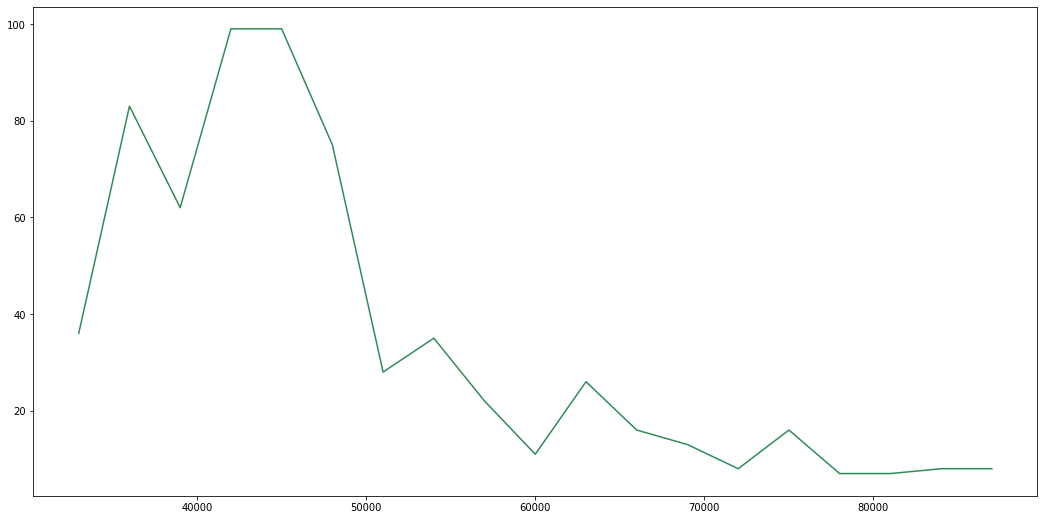

In [368]:
plt.figure(figsize = (18,9))
plt.plot(np.arange(33_000,90_000,3_000),y,color='seagreen')

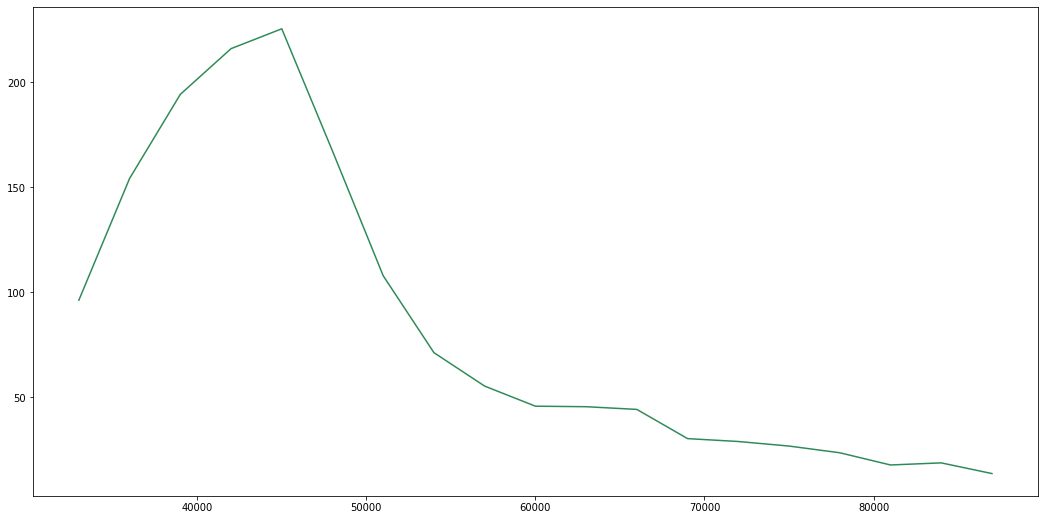

In [369]:
plt.figure(figsize = (18,9))
plt.plot(np.arange(33_000,90_000,3_000),smooted_val_cap,color='seagreen')

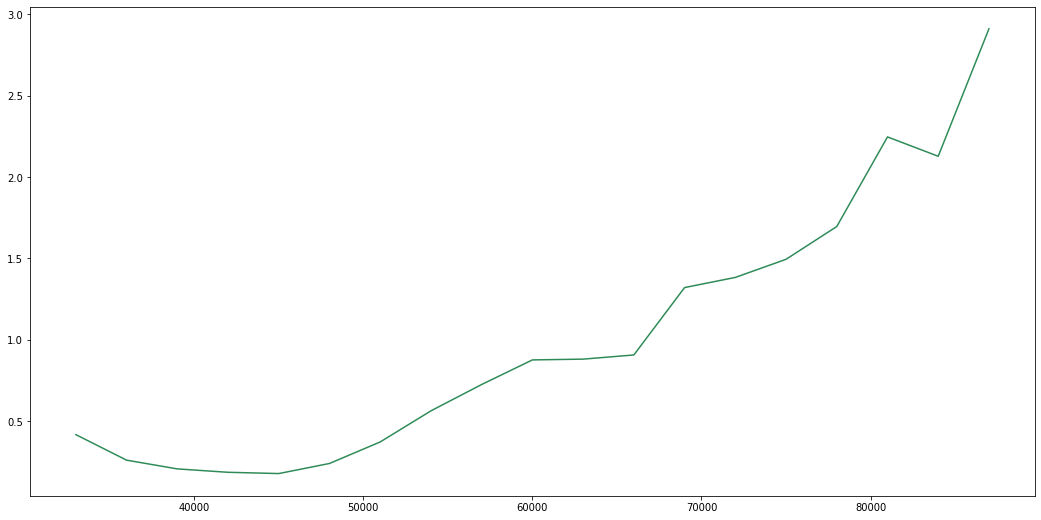

In [370]:
plt.figure(figsize = (18,9))
plt.plot(np.arange(33_000,90_000,3_000),wt_cap,color='seagreen')

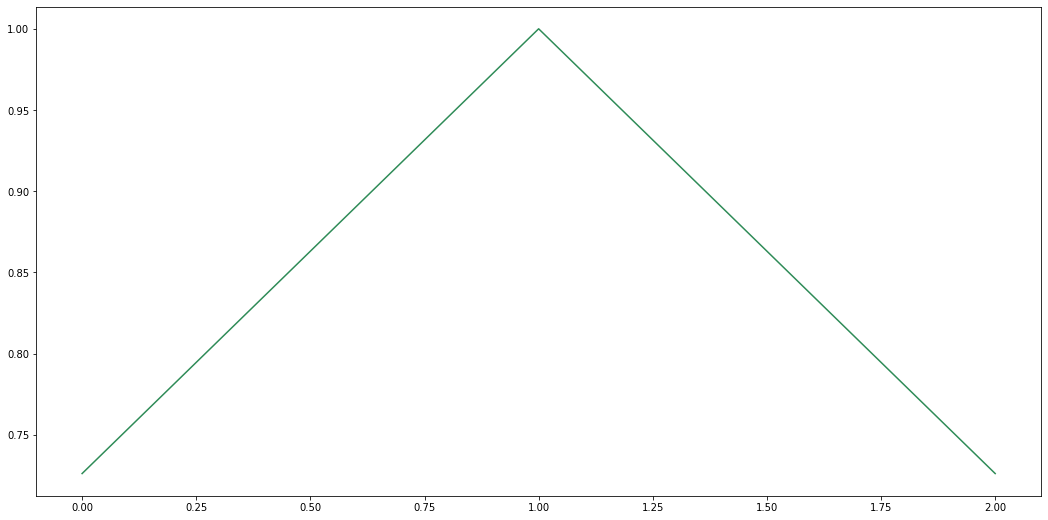

In [371]:
plt.figure(figsize = (18,9))
plt.plot(window_cap,color='seagreen')